## This notebook prepares for decoding (both 1D and 2D)
### Use this notebook to run session/day of each dataset from new animal

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import spyglass as nd
import pandas as pd
# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import logging
import os
#import cupy as cp

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')

In [4]:
from spyglass.common import (Session, IntervalList,IntervalPositionInfo,
                             LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common.common_interval import _intersection
from spyglass.common.common_position import IntervalLinearizedPosition

import spyglass.spikesorting.v0 as ss
from spyglass.spikesorting.v0 import (SortGroup, 
                                    SortInterval,
                                    SpikeSortingPreprocessingParameters,
                                    SpikeSortingRecording, 
                                    SpikeSorterParameters,
                                    SpikeSortingRecordingSelection,
                                    ArtifactDetectionParameters, ArtifactDetectionSelection,
                                    ArtifactRemovedIntervalList, ArtifactDetection,
                                      SpikeSortingSelection, SpikeSorting,
                                   CuratedSpikeSortingSelection,CuratedSpikeSorting,Curation)
from spyglass.decoding.v0.clusterless import (UnitMarks,
                                           UnitMarkParameters,UnitMarksIndicatorSelection,
                                          UnitMarksIndicator)
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common.common_position import IntervalPositionInfo, IntervalPositionInfoSelection

from replay_trajectory_classification.environments import Environment
from spyglass.common.common_position import TrackGraph
from spyglass.decoding.v0.clusterless import ClusterlessClassifierParameters
from replay_trajectory_classification import ClusterlessClassifier



import pprint
# Here are the analysis tables specific to Shijie Gu
from spyglass.shijiegu.Analysis_SGU import EpochPos,TrialChoice,Decode,DecodeResultsLinear
from spyglass.shijiegu.decodeHelpers import (thresholder_sort,
            runSessionNames,sleepSessionNames,populateUnitMarks,
            intersectValidIntervals)

[2025-06-13 18:06:19,087][INFO]: DataJoint 0.14.4 connected to shijiegu-alt@lmf-db.cin.ucsf.edu:3306
13-Jun-25 18:06:19 DataJoint 0.14.4 connected to shijiegu-alt@lmf-db.cin.ucsf.edu:3306


In [5]:
from spyglass.shijiegu.decodeHelpers import decodePrepMasterSession

## Table stream:
#### The thresholder sorter will fill `SpikeSorting`, then we fill `Curation`, `UnitMarks`
### 1. The final product is `UnitMarksIndicator`, which include spike and location

In [22]:
nwb_copy_file_name = 'klein20231111_.nwb'

In [23]:
session_interval, position_interval = runSessionNames(nwb_copy_file_name)
print(session_interval)

['02_Rev2Session1', '04_Rev2Session2', '06_Rev2Session3', '08_Rev2Session4', '10_Rev2Session5']


In [24]:
sleep_interval, sleep_position_interval = sleepSessionNames(nwb_copy_file_name)
print(session_interval)

['02_Rev2Session1', '04_Rev2Session2', '06_Rev2Session3', '08_Rev2Session4', '10_Rev2Session5']


In [ ]:
e = 0
sorting_keys = thresholder_sort(nwb_copy_file_name,session_interval[e],True)

0
inserting into IntervalList
done inserting into IntervalList
10
inserting into IntervalList
done inserting into IntervalList
11
inserting into IntervalList
done inserting into IntervalList
12
inserting into IntervalList
done inserting into IntervalList
15
inserting into IntervalList
done inserting into IntervalList
16
inserting into IntervalList
done inserting into IntervalList
28
inserting into IntervalList
done inserting into IntervalList
30
inserting into IntervalList
done inserting into IntervalList
36
inserting into IntervalList
done inserting into IntervalList
45
inserting into IntervalList
done inserting into IntervalList
52
inserting into IntervalList
done inserting into IntervalList
53
inserting into IntervalList
done inserting into IntervalList
54
inserting into IntervalList
done inserting into IntervalList


[15:55:56][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'klein20231105_.nwb', 'sort_group_id': 0, 'sort_interval_name': '02_Rev2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'klein20231105_.nwb_02_Rev2Session1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
30-May-25 15:55:56 Running spike sorting on {'nwb_file_name': 'klein20231105_.nwb', 'sort_group_id': 0, 'sort_interval_name': '02_Rev2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'klein20231105_.nwb_02_Rev2Session1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...


detect peaks using locally_exclusive:   0%|          | 0/2769 [00:00<?, ?it/s]

In [50]:
mark_parameters_keys = populateUnitMarks(sorting_keys)

[23:06:56][WARNING] Spyglass: Turning off transaction protection this table by default. Use use_transation=True to re-enable.
Read more about transactions:
https://docs.datajoint.io/python/definition/05-Transactions.html
https://github.com/LorenFrankLab/spyglass/issues/1030
24-Apr-25 23:06:56 Turning off transaction protection this table by default. Use use_transation=True to re-enable.
Read more about transactions:
https://docs.datajoint.io/python/definition/05-Transactions.html
https://github.com/LorenFrankLab/spyglass/issues/1030


In [42]:
#%debug

In [139]:
(ArtifactDetectionSelection & {"nwb_file_name":nwb_copy_file_name,
                              "sort_interval_name":"04_Seq2Session2"}).fetch()

array([('julio20230811_.nwb', 100, '04_Seq2Session2', 'franklab_tetrode_hippocampus', 'SequenceTask', 'ampl_100_prop_05_2ms', 0),
       ('julio20230811_.nwb', 101, '04_Seq2Session2', 'franklab_tetrode_hippocampus', 'SequenceTask', 'ampl_100_prop_05_2ms', 0)],
      dtype=[('nwb_file_name', 'O'), ('sort_group_id', '<i8'), ('sort_interval_name', 'O'), ('preproc_params_name', 'O'), ('team_name', 'O'), ('artifact_params_name', 'O'), ('custom_artifact_detection', '<i8')])

In [17]:
mark_parameters_keys = populateUnitMarks(sorting_keys)

[19:43:37][INFO] Spyglass: Found 1 accepted units
20-Apr-25 19:43:37 Found 1 accepted units
[19:43:40][INFO] Spyglass: Writing new NWB file Julio20230811_JGOX33B0QD.nwb
20-Apr-25 19:43:40 Writing new NWB file Julio20230811_JGOX33B0QD.nwb
[19:43:42][INFO] Spyglass: Found 1 accepted units
20-Apr-25 19:43:42 Found 1 accepted units
[19:43:43][INFO] Spyglass: Writing new NWB file Julio20230811_KNJ3K0S4OZ.nwb
20-Apr-25 19:43:43 Writing new NWB file Julio20230811_KNJ3K0S4OZ.nwb
[19:43:44][INFO] Spyglass: Found 1 accepted units
20-Apr-25 19:43:44 Found 1 accepted units
[19:43:45][INFO] Spyglass: Writing new NWB file Julio20230811_K0EQEE75MM.nwb
20-Apr-25 19:43:45 Writing new NWB file Julio20230811_K0EQEE75MM.nwb
[19:43:47][INFO] Spyglass: Found 1 accepted units
20-Apr-25 19:43:47 Found 1 accepted units
[19:43:48][INFO] Spyglass: Writing new NWB file Julio20230811_2RWH63BQCZ.nwb
20-Apr-25 19:43:48 Writing new NWB file Julio20230811_2RWH63BQCZ.nwb
[19:43:49][INFO] Spyglass: Found 1 accepted unit

extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:44:44][INFO] Spyglass: Writing new NWB file Julio20230811_NAXP791IN4.nwb
20-Apr-25 19:44:44 Writing new NWB file Julio20230811_NAXP791IN4.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:44:47][INFO] Spyglass: Writing new NWB file Julio20230811_2RPYIZQFIH.nwb
20-Apr-25 19:44:47 Writing new NWB file Julio20230811_2RPYIZQFIH.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:44:49][INFO] Spyglass: Writing new NWB file Julio20230811_HLL1PQII0A.nwb
20-Apr-25 19:44:49 Writing new NWB file Julio20230811_HLL1PQII0A.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:44:52][INFO] Spyglass: Writing new NWB file Julio20230811_ROD0TU372R.nwb
20-Apr-25 19:44:52 Writing new NWB file Julio20230811_ROD0TU372R.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:44:54][INFO] Spyglass: Writing new NWB file Julio20230811_YWOBB3H9H8.nwb
20-Apr-25 19:44:54 Writing new NWB file Julio20230811_YWOBB3H9H8.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:44:57][INFO] Spyglass: Writing new NWB file Julio20230811_W83ZMOSG4T.nwb
20-Apr-25 19:44:57 Writing new NWB file Julio20230811_W83ZMOSG4T.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:45:00][INFO] Spyglass: Writing new NWB file Julio20230811_UMUM237U7U.nwb
20-Apr-25 19:45:00 Writing new NWB file Julio20230811_UMUM237U7U.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:45:03][INFO] Spyglass: Writing new NWB file Julio20230811_5APZP0XA8X.nwb
20-Apr-25 19:45:03 Writing new NWB file Julio20230811_5APZP0XA8X.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:45:06][INFO] Spyglass: Writing new NWB file Julio20230811_6RNA99MWGE.nwb
20-Apr-25 19:45:06 Writing new NWB file Julio20230811_6RNA99MWGE.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:45:09][INFO] Spyglass: Writing new NWB file Julio20230811_B6MWR2ZFH0.nwb
20-Apr-25 19:45:09 Writing new NWB file Julio20230811_B6MWR2ZFH0.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:45:11][INFO] Spyglass: Writing new NWB file Julio20230811_HX754JEFN8.nwb
20-Apr-25 19:45:11 Writing new NWB file Julio20230811_HX754JEFN8.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:45:14][INFO] Spyglass: Writing new NWB file Julio20230811_5BMC8QXW42.nwb
20-Apr-25 19:45:14 Writing new NWB file Julio20230811_5BMC8QXW42.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:45:17][INFO] Spyglass: Writing new NWB file Julio20230811_ED2QB08M2S.nwb
20-Apr-25 19:45:17 Writing new NWB file Julio20230811_ED2QB08M2S.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:45:20][INFO] Spyglass: Writing new NWB file Julio20230811_M5XRJ4VTG3.nwb
20-Apr-25 19:45:20 Writing new NWB file Julio20230811_M5XRJ4VTG3.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:45:22][INFO] Spyglass: Writing new NWB file Julio20230811_RM30MLTS30.nwb
20-Apr-25 19:45:22 Writing new NWB file Julio20230811_RM30MLTS30.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:45:26][INFO] Spyglass: Writing new NWB file Julio20230811_XN20B0G86F.nwb
20-Apr-25 19:45:26 Writing new NWB file Julio20230811_XN20B0G86F.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:45:28][INFO] Spyglass: Writing new NWB file Julio20230811_2BVU7NBJC4.nwb
20-Apr-25 19:45:28 Writing new NWB file Julio20230811_2BVU7NBJC4.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:45:31][INFO] Spyglass: Writing new NWB file Julio20230811_M4JE3LQF6P.nwb
20-Apr-25 19:45:31 Writing new NWB file Julio20230811_M4JE3LQF6P.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:45:34][INFO] Spyglass: Writing new NWB file Julio20230811_FTIGK58148.nwb
20-Apr-25 19:45:34 Writing new NWB file Julio20230811_FTIGK58148.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:45:37][INFO] Spyglass: Writing new NWB file Julio20230811_U4HCQJS8BQ.nwb
20-Apr-25 19:45:37 Writing new NWB file Julio20230811_U4HCQJS8BQ.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:45:40][INFO] Spyglass: Writing new NWB file Julio20230811_8KH9A3Z6N7.nwb
20-Apr-25 19:45:40 Writing new NWB file Julio20230811_8KH9A3Z6N7.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:45:42][INFO] Spyglass: Writing new NWB file Julio20230811_XNNX1Z266N.nwb
20-Apr-25 19:45:42 Writing new NWB file Julio20230811_XNNX1Z266N.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:45:45][INFO] Spyglass: Writing new NWB file Julio20230811_30EKCH88IC.nwb
20-Apr-25 19:45:45 Writing new NWB file Julio20230811_30EKCH88IC.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:45:48][INFO] Spyglass: Writing new NWB file Julio20230811_7UZRASL88A.nwb
20-Apr-25 19:45:48 Writing new NWB file Julio20230811_7UZRASL88A.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:45:51][INFO] Spyglass: Writing new NWB file Julio20230811_PCUCZEL3YT.nwb
20-Apr-25 19:45:51 Writing new NWB file Julio20230811_PCUCZEL3YT.nwb


In [65]:
(SpikeSorting & {'nwb_file_name': nwb_copy_file_name})

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,sorter,sorter_params_name,artifact_removed_interval_list_name,sorting_path,"time_of_sort in Unix time, to the nearest second"
klein20231105_.nwb,0,02_Rev2Session1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,klein20231105_.nwb_02_Rev2Session1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/klein20231105_.nwb_02_Rev2Session1_0_franklab_tetrode_hippocampus_1bec9c47_spikesorting,1748645792
klein20231105_.nwb,10,02_Rev2Session1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,klein20231105_.nwb_02_Rev2Session1_10_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/klein20231105_.nwb_02_Rev2Session1_10_franklab_tetrode_hippocampus_e469aa10_spikesorting,1748645837
klein20231105_.nwb,11,02_Rev2Session1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,klein20231105_.nwb_02_Rev2Session1_11_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/klein20231105_.nwb_02_Rev2Session1_11_franklab_tetrode_hippocampus_cc42212d_spikesorting,1748645898
klein20231105_.nwb,12,02_Rev2Session1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,klein20231105_.nwb_02_Rev2Session1_12_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/klein20231105_.nwb_02_Rev2Session1_12_franklab_tetrode_hippocampus_8efe4a1b_spikesorting,1748645949
klein20231105_.nwb,15,02_Rev2Session1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,klein20231105_.nwb_02_Rev2Session1_15_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/klein20231105_.nwb_02_Rev2Session1_15_franklab_tetrode_hippocampus_3b78586e_spikesorting,1748646008
klein20231105_.nwb,16,02_Rev2Session1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,klein20231105_.nwb_02_Rev2Session1_16_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/klein20231105_.nwb_02_Rev2Session1_16_franklab_tetrode_hippocampus_3040bbfb_spikesorting,1748646094
klein20231105_.nwb,28,02_Rev2Session1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,klein20231105_.nwb_02_Rev2Session1_28_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/klein20231105_.nwb_02_Rev2Session1_28_franklab_tetrode_hippocampus_75ad47c2_spikesorting,1748646149
klein20231105_.nwb,30,02_Rev2Session1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,klein20231105_.nwb_02_Rev2Session1_30_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/klein20231105_.nwb_02_Rev2Session1_30_franklab_tetrode_hippocampus_c4696e07_spikesorting,1748646195
klein20231105_.nwb,36,02_Rev2Session1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,klein20231105_.nwb_02_Rev2Session1_36_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/klein20231105_.nwb_02_Rev2Session1_36_franklab_tetrode_hippocampus_6cd196e3_spikesorting,1748646245
klein20231105_.nwb,45,02_Rev2Session1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,klein20231105_.nwb_02_Rev2Session1_45_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/klein20231105_.nwb_02_Rev2Session1_45_franklab_tetrode_hippocampus_7c84368c_spikesorting,1748646294


In [60]:
import spikeinterface as si

In [56]:
nwb_copy_file_name = 'julio20230731_.nwb'
session_interval, position_interval = runSessionNames(nwb_copy_file_name)
print(session_interval)

['02_Seq2Session1', '04_Seq2Session2', '06_Seq2Session3', '08_Seq2Session4', '10_Seq2Session5', '12_Seq2Session6']


In [57]:
sort_interval_name = '06_Seq2Session3'
#array([('julio20230811_.nwb', 100, '04_Seq2Session2', 'franklab_tetrode_hippocampus', 'SequenceTask', 'ampl_100_prop_05_2ms', 0),
#       ('julio20230811_.nwb', 101, '04_Seq2Session2', 'franklab_tetrode_hippocampus', 'SequenceTask', 'ampl_100_prop_05_2ms', 0)],
      
from spyglass.shijiegu.helpers import interval_union

In [70]:
statescript_key = {'nwb_file_name':nwb_copy_file_name,
                   'epoch_name':sort_interval_name}

StateScript = pd.DataFrame(
    (TrialChoice & statescript_key).fetch1('choice_reward'))
trial_1_t = StateScript.loc[1].timestamp_O
trial_last_t = np.nanmax(StateScript.timestamp_O)

1690835382.869646

In [61]:
key = {'nwb_file_name' : nwb_copy_file_name,
       'sort_interval_name':sort_interval_name,
       "preproc_params_name":"franklab_tetrode_hippocampus",
       "sort_group_id":100}
recording_path = (SpikeSortingRecording & key).fetch1(
                "recording_path"
            )
recording_name = SpikeSortingRecording._get_recording_name(key)
recording = si.load_extractor(recording_path)

In [62]:
if recording.get_num_segments() > 1:
    valid_timestamps = np.array([])
    for segment in range(recording.get_num_segments()):
        valid_timestamps = np.concatenate(
                (valid_timestamps, recording.get_times(segment_index=segment))
        )
    recording = si.concatenate_recordings([recording])
elif recording.get_num_segments() == 1:
    valid_timestamps = recording.get_times(0)

In [63]:
valid_timestamps.shape

(53007427,)

In [65]:
from spyglass.spikesorting.v0.spikesorting_artifact import _get_artifact_times

In [66]:
artifact_removed_test, artifact_intervals = _get_artifact_times(recording,
                                                                amplitude_thresh = 100, proportion_above_thresh = 0.5)

[21:19:27][INFO] Spyglass: Using 1 jobs...
26-May-25 21:19:27 Using 1 jobs...


In [42]:
#%debug

ValueError: Axis limits cannot be NaN or Inf

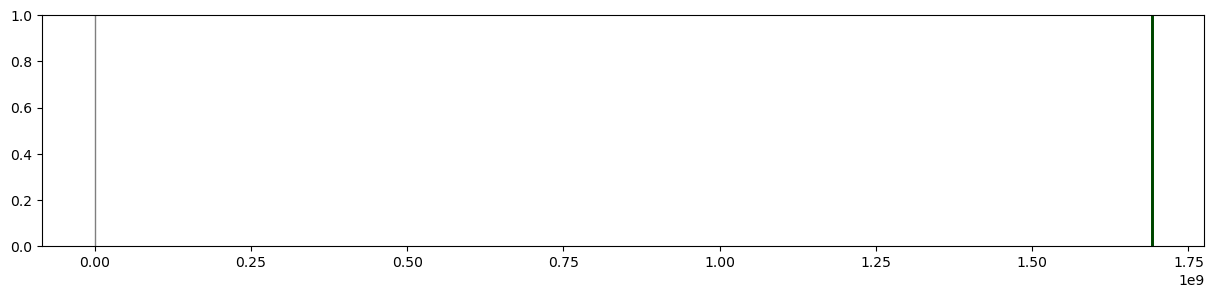

In [67]:
fig, ax = plt.subplots(1,1,figsize = (15,3))

for a_ind in range(artifact_removed_test.shape[0]):
    ax.axvspan(artifact_removed_test[a_ind][0],artifact_removed_test[a_ind][1],color = 'g',linewidth = 1)
    ax.axvspan(artifact_intervals[a_ind][0],artifact_intervals[a_ind][1],color = 'k',linewidth = 1,alpha = 0.5)

ax.set_xlim(trial_1_t-100,trial_last_t+100)

In [15]:
valid_timestamps[0]

1691786105.633824

In [16]:
recording

BinaryFolderRecording: 60 channels - 30.0kHz - 1 segments - 29,895,878 samples 
                       997.88s (16.63 minutes) - int16 dtype - 3.34 GiB

In [174]:
(SpikeSortingRecording & )

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,recording_path,sort_interval_list_name descriptive name of this interval list
julio20230811_.nwb,100,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,/stelmo/nwb/recording/julio20230811_.nwb_06_Seq2Session3_100_franklab_tetrode_hippocampus,julio20230811_.nwb_06_Seq2Session3_100_franklab_tetrode_hippocampus


In [11]:
"""fetch artifact"""
artifact_params_name='ampl_100_prop_05_2ms'
sort_interval_name = '02_Seq2Session1'
artifact_key=(ArtifactDetection() & {'nwb_file_name' : nwb_copy_file_name}
                            & {'artifact_params_name': artifact_params_name}
                            & {'sort_interval_name':sort_interval_name})

#, and there should be 2 entries, one from left cannula (group 100), and one from right cannula (group 101)
artifact_removed_name_list=artifact_key.fetch('artifact_removed_interval_list_name')

artifact_time_list=[]
artifact_removed_time_list=[]
for artifact_removed_name in artifact_removed_name_list:
    artifact_time_list.append((ArtifactDetection() & {'nwb_file_name' : nwb_copy_file_name,'artifact_removed_interval_list_name':artifact_removed_name}).fetch1('artifact_times'))
    (IntervalList() & {'nwb_file_name' : nwb_copy_file_name,'interval_list_name':artifact_removed_name}).delete()


[17:10:10][INFO] Spyglass: Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
24-Apr-25 17:10:10 Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
[17:10:10][INFO] Spyglass: Checking  0: IntervalList -> ['Session']
24-Apr-25 17:10:10 Checking  0: IntervalList -> ['Session']
[17:10:10][INFO] Spyglass: Bridge Link: IntervalList -> Session: result partial
24-Apr-25 17:10:10 Bridge Link: IntervalList -> Session: result partial
[17:10:10][INFO] Spyglass: Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
24-Apr-25 17:10:10 Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
[17:10:10][INFO] Spyglass: Banned Tbl : Nwbfile
24-Apr-25 17:10:10 Banned Tbl : Nwbfile
[17:10:10][INFO] Spyglass: Banned Tbl : Subject
24-Apr-25 17:10:10 Banned Tbl : Subject
[17:10:10][INFO] Spyglass: Banned Tbl : Institution
24-Apr-25 17:10:10 Banned Tbl : Institution
[17:10:10][INFO] Spy

Commit deletes? [yes, No]:  No


[2025-04-24 17:10:18,417][WARNING]: Deletes cancelled
24-Apr-25 17:10:18 Deletes cancelled
[17:10:22][INFO] Spyglass: Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
24-Apr-25 17:10:22 Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
[17:10:22][INFO] Spyglass: Checking  0: IntervalList -> ['Session']
24-Apr-25 17:10:22 Checking  0: IntervalList -> ['Session']
[17:10:22][INFO] Spyglass: Bridge Link: IntervalList -> Session: result partial
24-Apr-25 17:10:22 Bridge Link: IntervalList -> Session: result partial
[17:10:22][INFO] Spyglass: Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
24-Apr-25 17:10:22 Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
[17:10:22][INFO] Spyglass: Banned Tbl : Nwbfile
24-Apr-25 17:10:22 Banned Tbl : Nwbfile
[17:10:22][INFO] Spyglass: Banned Tbl : Subject
24-Apr-25 17:10:22 Banned Tbl : Subject
[17:10:22][INFO] Spyglass

Commit deletes? [yes, No]:  No


[2025-04-24 17:10:33,469][WARNING]: Deletes cancelled
24-Apr-25 17:10:33 Deletes cancelled


KeyboardInterrupt: 

In [52]:
intvls = (IntervalList() & {'nwb_file_name' : nwb_copy_file_name}).fetch("interval_list_name")

In [53]:
intvls

array(['01_Rev2Sleep1', '02_Rev2Session1',
       '02_Rev2Session1 lfp band 1000Hz', '03_Rev2Sleep2',
       '04_Rev2Session2', '04_Rev2Session2 lfp band 1000Hz',
       '05_Rev2Sleep3', '06_Rev2Session3',
       '06_Rev2Session3 lfp band 1000Hz', '07_Rev2Sleep4',
       '08_Rev2Session4', '08_Rev2Session4 lfp band 1000Hz',
       '09_Rev2Sleep5', '10_Rev2Session5',
       '10_Rev2Session5 lfp band 1000Hz', '11_Rev2Sleep6',
       'klein20231102_.nwb_01_Rev2Sleep1_0_franklab_tetrode_hippocampus',
       'klein20231102_.nwb_01_Rev2Sleep1_100_franklab_tetrode_hippocampus',
       'klein20231102_.nwb_01_Rev2Sleep1_100_franklab_tetrode_hippocampus_ampl_100_prop_05_2ms_artifact_removed_valid_times',
       'klein20231102_.nwb_01_Rev2Sleep1_101_franklab_tetrode_hippocampus',
       'klein20231102_.nwb_01_Rev2Sleep1_101_franklab_tetrode_hippocampus_ampl_100_prop_05_2ms_artifact_removed_valid_times',
       'klein20231102_.nwb_01_Rev2Sleep1_10_franklab_tetrode_hippocampus',
       'klein202311

In [54]:
for intvl in intvls:
    if "artifact" in intvl:
    #if "06_Seq2Session3" in intvl and "track_time_only" in intvl:
        (IntervalList() & {'nwb_file_name' : nwb_copy_file_name,
                   "interval_list_name":intvl}).delete()

[21:35:13][INFO] Spyglass: Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
30-May-25 21:35:13 Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
[21:35:13][INFO] Spyglass: Checking  0: IntervalList -> ['Session']
30-May-25 21:35:13 Checking  0: IntervalList -> ['Session']
[21:35:13][INFO] Spyglass: Bridge Link: IntervalList -> Session: result partial
30-May-25 21:35:13 Bridge Link: IntervalList -> Session: result partial
[21:35:13][INFO] Spyglass: Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
30-May-25 21:35:13 Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
[21:35:13][INFO] Spyglass: Banned Tbl : Nwbfile
30-May-25 21:35:13 Banned Tbl : Nwbfile
[21:35:13][INFO] Spyglass: Banned Tbl : Subject
30-May-25 21:35:13 Banned Tbl : Subject
[21:35:13][INFO] Spyglass: Banned Tbl : Institution
30-May-25 21:35:13 Banned Tbl : Institution
[21:35:13][INFO] Spy

Commit deletes? [yes, No]:  yes


[2025-05-30 21:35:15,403][INFO]: Deletes committed.
30-May-25 21:35:15 Deletes committed.
[21:35:19][INFO] Spyglass: Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
30-May-25 21:35:19 Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
[21:35:19][INFO] Spyglass: Checking  0: IntervalList -> ['Session']
30-May-25 21:35:19 Checking  0: IntervalList -> ['Session']
[21:35:19][INFO] Spyglass: Bridge Link: IntervalList -> Session: result partial
30-May-25 21:35:19 Bridge Link: IntervalList -> Session: result partial
[21:35:19][INFO] Spyglass: Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
30-May-25 21:35:19 Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
[21:35:19][INFO] Spyglass: Banned Tbl : Nwbfile
30-May-25 21:35:19 Banned Tbl : Nwbfile
[21:35:19][INFO] Spyglass: Banned Tbl : Subject
30-May-25 21:35:19 Banned Tbl : Subject
[21:35:19][INFO] Spyglass:

Commit deletes? [yes, No]:  yes


[2025-05-30 21:35:22,474][INFO]: Deletes committed.
30-May-25 21:35:22 Deletes committed.
[21:35:26][INFO] Spyglass: Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
30-May-25 21:35:26 Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
[21:35:26][INFO] Spyglass: Checking  0: IntervalList -> ['Session']
30-May-25 21:35:26 Checking  0: IntervalList -> ['Session']
[21:35:26][INFO] Spyglass: Bridge Link: IntervalList -> Session: result partial
30-May-25 21:35:26 Bridge Link: IntervalList -> Session: result partial
[21:35:26][INFO] Spyglass: Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
30-May-25 21:35:26 Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
[21:35:26][INFO] Spyglass: Banned Tbl : Nwbfile
30-May-25 21:35:26 Banned Tbl : Nwbfile
[21:35:26][INFO] Spyglass: Banned Tbl : Subject
30-May-25 21:35:26 Banned Tbl : Subject
[21:35:26][INFO] Spyglass:

Commit deletes? [yes, No]:  yes


[2025-05-30 21:35:29,152][INFO]: Deletes committed.
30-May-25 21:35:29 Deletes committed.
[21:35:33][INFO] Spyglass: Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
30-May-25 21:35:33 Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
[21:35:33][INFO] Spyglass: Checking  0: IntervalList -> ['Session']
30-May-25 21:35:33 Checking  0: IntervalList -> ['Session']
[21:35:33][INFO] Spyglass: Bridge Link: IntervalList -> Session: result partial
30-May-25 21:35:33 Bridge Link: IntervalList -> Session: result partial
[21:35:33][INFO] Spyglass: Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
30-May-25 21:35:33 Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
[21:35:33][INFO] Spyglass: Banned Tbl : Nwbfile
30-May-25 21:35:33 Banned Tbl : Nwbfile
[21:35:33][INFO] Spyglass: Banned Tbl : Subject
30-May-25 21:35:33 Banned Tbl : Subject
[21:35:33][INFO] Spyglass:

Commit deletes? [yes, No]:  yes


[2025-05-30 21:35:35,070][INFO]: Deletes committed.
30-May-25 21:35:35 Deletes committed.
[21:35:39][INFO] Spyglass: Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
30-May-25 21:35:39 Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
[21:35:39][INFO] Spyglass: Checking  0: IntervalList -> ['Session']
30-May-25 21:35:39 Checking  0: IntervalList -> ['Session']
[21:35:39][INFO] Spyglass: Bridge Link: IntervalList -> Session: result partial
30-May-25 21:35:39 Bridge Link: IntervalList -> Session: result partial
[21:35:39][INFO] Spyglass: Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
30-May-25 21:35:39 Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
[21:35:39][INFO] Spyglass: Banned Tbl : Nwbfile
30-May-25 21:35:39 Banned Tbl : Nwbfile
[21:35:39][INFO] Spyglass: Banned Tbl : Subject
30-May-25 21:35:39 Banned Tbl : Subject
[21:35:39][INFO] Spyglass:

Commit deletes? [yes, No]:  yes


[2025-05-30 21:35:41,026][INFO]: Deletes committed.
30-May-25 21:35:41 Deletes committed.
[21:35:45][INFO] Spyglass: Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
30-May-25 21:35:45 Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
[21:35:45][INFO] Spyglass: Checking  0: IntervalList -> ['Session']
30-May-25 21:35:45 Checking  0: IntervalList -> ['Session']
[21:35:45][INFO] Spyglass: Bridge Link: IntervalList -> Session: result partial
30-May-25 21:35:45 Bridge Link: IntervalList -> Session: result partial
[21:35:45][INFO] Spyglass: Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
30-May-25 21:35:45 Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
[21:35:45][INFO] Spyglass: Banned Tbl : Nwbfile
30-May-25 21:35:45 Banned Tbl : Nwbfile
[21:35:45][INFO] Spyglass: Banned Tbl : Subject
30-May-25 21:35:45 Banned Tbl : Subject
[21:35:45][INFO] Spyglass:

Commit deletes? [yes, No]:  yes


[2025-05-30 21:35:47,518][INFO]: Deletes committed.
30-May-25 21:35:47 Deletes committed.
[21:35:52][INFO] Spyglass: Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
30-May-25 21:35:52 Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
[21:35:52][INFO] Spyglass: Checking  0: IntervalList -> ['Session']
30-May-25 21:35:52 Checking  0: IntervalList -> ['Session']
[21:35:52][INFO] Spyglass: Bridge Link: IntervalList -> Session: result partial
30-May-25 21:35:52 Bridge Link: IntervalList -> Session: result partial
[21:35:52][INFO] Spyglass: Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
30-May-25 21:35:52 Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
[21:35:52][INFO] Spyglass: Banned Tbl : Nwbfile
30-May-25 21:35:52 Banned Tbl : Nwbfile
[21:35:52][INFO] Spyglass: Banned Tbl : Subject
30-May-25 21:35:52 Banned Tbl : Subject
[21:35:52][INFO] Spyglass:

Commit deletes? [yes, No]:  yes


[2025-05-30 21:35:53,886][INFO]: Deletes committed.
30-May-25 21:35:53 Deletes committed.
[21:35:59][INFO] Spyglass: Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
30-May-25 21:35:59 Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
[21:35:59][INFO] Spyglass: Checking  0: IntervalList -> ['Session']
30-May-25 21:35:59 Checking  0: IntervalList -> ['Session']
[21:35:59][INFO] Spyglass: Bridge Link: IntervalList -> Session: result partial
30-May-25 21:35:59 Bridge Link: IntervalList -> Session: result partial
[21:35:59][INFO] Spyglass: Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
30-May-25 21:35:59 Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
[21:35:59][INFO] Spyglass: Banned Tbl : Nwbfile
30-May-25 21:35:59 Banned Tbl : Nwbfile
[21:35:59][INFO] Spyglass: Banned Tbl : Subject
30-May-25 21:35:59 Banned Tbl : Subject
[21:35:59][INFO] Spyglass:

Commit deletes? [yes, No]:  yes


[2025-05-30 21:36:01,411][INFO]: Deletes committed.
30-May-25 21:36:01 Deletes committed.
[21:36:05][INFO] Spyglass: Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
30-May-25 21:36:05 Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
[21:36:05][INFO] Spyglass: Checking  0: IntervalList -> ['Session']
30-May-25 21:36:05 Checking  0: IntervalList -> ['Session']
[21:36:05][INFO] Spyglass: Bridge Link: IntervalList -> Session: result partial
30-May-25 21:36:05 Bridge Link: IntervalList -> Session: result partial
[21:36:05][INFO] Spyglass: Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
30-May-25 21:36:05 Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
[21:36:05][INFO] Spyglass: Banned Tbl : Nwbfile
30-May-25 21:36:05 Banned Tbl : Nwbfile
[21:36:05][INFO] Spyglass: Banned Tbl : Subject
30-May-25 21:36:05 Banned Tbl : Subject
[21:36:05][INFO] Spyglass:

Commit deletes? [yes, No]:  yes


[2025-05-30 21:36:07,536][INFO]: Deletes committed.
30-May-25 21:36:07 Deletes committed.
[21:36:11][INFO] Spyglass: Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
30-May-25 21:36:11 Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
[21:36:11][INFO] Spyglass: Checking  0: IntervalList -> ['Session']
30-May-25 21:36:11 Checking  0: IntervalList -> ['Session']
[21:36:11][INFO] Spyglass: Bridge Link: IntervalList -> Session: result partial
30-May-25 21:36:11 Bridge Link: IntervalList -> Session: result partial
[21:36:11][INFO] Spyglass: Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
30-May-25 21:36:11 Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
[21:36:11][INFO] Spyglass: Banned Tbl : Nwbfile
30-May-25 21:36:11 Banned Tbl : Nwbfile
[21:36:11][INFO] Spyglass: Banned Tbl : Subject
30-May-25 21:36:11 Banned Tbl : Subject
[21:36:11][INFO] Spyglass:

Commit deletes? [yes, No]:  yes


[2025-05-30 21:36:13,413][INFO]: Deletes committed.
30-May-25 21:36:13 Deletes committed.
[21:36:17][INFO] Spyglass: Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
30-May-25 21:36:17 Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
[21:36:17][INFO] Spyglass: Checking  0: IntervalList -> ['Session']
30-May-25 21:36:17 Checking  0: IntervalList -> ['Session']
[21:36:17][INFO] Spyglass: Bridge Link: IntervalList -> Session: result partial
30-May-25 21:36:17 Bridge Link: IntervalList -> Session: result partial
[21:36:17][INFO] Spyglass: Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
30-May-25 21:36:17 Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
[21:36:17][INFO] Spyglass: Banned Tbl : Nwbfile
30-May-25 21:36:17 Banned Tbl : Nwbfile
[21:36:17][INFO] Spyglass: Banned Tbl : Subject
30-May-25 21:36:17 Banned Tbl : Subject
[21:36:17][INFO] Spyglass:

Commit deletes? [yes, No]:  yes


[2025-05-30 21:36:19,779][INFO]: Deletes committed.
30-May-25 21:36:19 Deletes committed.
[21:36:24][INFO] Spyglass: Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
30-May-25 21:36:24 Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
[21:36:24][INFO] Spyglass: Checking  0: IntervalList -> ['Session']
30-May-25 21:36:24 Checking  0: IntervalList -> ['Session']
[21:36:24][INFO] Spyglass: Bridge Link: IntervalList -> Session: result partial
30-May-25 21:36:24 Bridge Link: IntervalList -> Session: result partial
[21:36:24][INFO] Spyglass: Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
30-May-25 21:36:24 Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
[21:36:24][INFO] Spyglass: Banned Tbl : Nwbfile
30-May-25 21:36:24 Banned Tbl : Nwbfile
[21:36:24][INFO] Spyglass: Banned Tbl : Subject
30-May-25 21:36:24 Banned Tbl : Subject
[21:36:24][INFO] Spyglass:

Commit deletes? [yes, No]:  yes


[2025-05-30 21:36:25,971][INFO]: Deletes committed.
30-May-25 21:36:25 Deletes committed.
[21:36:30][INFO] Spyglass: Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
30-May-25 21:36:30 Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
[21:36:30][INFO] Spyglass: Checking  0: IntervalList -> ['Session']
30-May-25 21:36:30 Checking  0: IntervalList -> ['Session']
[21:36:30][INFO] Spyglass: Bridge Link: IntervalList -> Session: result partial
30-May-25 21:36:30 Bridge Link: IntervalList -> Session: result partial
[21:36:30][INFO] Spyglass: Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
30-May-25 21:36:30 Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
[21:36:30][INFO] Spyglass: Banned Tbl : Nwbfile
30-May-25 21:36:30 Banned Tbl : Nwbfile
[21:36:30][INFO] Spyglass: Banned Tbl : Subject
30-May-25 21:36:30 Banned Tbl : Subject
[21:36:30][INFO] Spyglass:

Commit deletes? [yes, No]:  yes


[2025-05-30 21:37:27,015][INFO]: Deletes committed.
30-May-25 21:37:27 Deletes committed.
[21:37:31][INFO] Spyglass: Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
30-May-25 21:37:31 Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
[21:37:31][INFO] Spyglass: Checking  0: IntervalList -> ['Session']
30-May-25 21:37:31 Checking  0: IntervalList -> ['Session']
[21:37:31][INFO] Spyglass: Bridge Link: IntervalList -> Session: result partial
30-May-25 21:37:31 Bridge Link: IntervalList -> Session: result partial
[21:37:31][INFO] Spyglass: Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
30-May-25 21:37:31 Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
[21:37:31][INFO] Spyglass: Banned Tbl : Nwbfile
30-May-25 21:37:31 Banned Tbl : Nwbfile
[21:37:31][INFO] Spyglass: Banned Tbl : Subject
30-May-25 21:37:31 Banned Tbl : Subject
[21:37:31][INFO] Spyglass:

Commit deletes? [yes, No]:  yes


[2025-05-30 21:37:33,350][INFO]: Deletes committed.
30-May-25 21:37:33 Deletes committed.
[21:37:37][INFO] Spyglass: Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
30-May-25 21:37:37 Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
[21:37:37][INFO] Spyglass: Checking  0: IntervalList -> ['Session']
30-May-25 21:37:37 Checking  0: IntervalList -> ['Session']
[21:37:37][INFO] Spyglass: Bridge Link: IntervalList -> Session: result partial
30-May-25 21:37:37 Bridge Link: IntervalList -> Session: result partial
[21:37:37][INFO] Spyglass: Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
30-May-25 21:37:37 Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
[21:37:37][INFO] Spyglass: Banned Tbl : Nwbfile
30-May-25 21:37:37 Banned Tbl : Nwbfile
[21:37:37][INFO] Spyglass: Banned Tbl : Subject
30-May-25 21:37:37 Banned Tbl : Subject
[21:37:37][INFO] Spyglass:

Commit deletes? [yes, No]:  yes


[2025-05-30 21:37:39,457][INFO]: Deletes committed.
30-May-25 21:37:39 Deletes committed.
[21:37:43][INFO] Spyglass: Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
30-May-25 21:37:43 Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
[21:37:43][INFO] Spyglass: Checking  0: IntervalList -> ['Session']
30-May-25 21:37:43 Checking  0: IntervalList -> ['Session']
[21:37:43][INFO] Spyglass: Bridge Link: IntervalList -> Session: result partial
30-May-25 21:37:43 Bridge Link: IntervalList -> Session: result partial
[21:37:43][INFO] Spyglass: Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
30-May-25 21:37:43 Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
[21:37:43][INFO] Spyglass: Banned Tbl : Nwbfile
30-May-25 21:37:43 Banned Tbl : Nwbfile
[21:37:43][INFO] Spyglass: Banned Tbl : Subject
30-May-25 21:37:43 Banned Tbl : Subject
[21:37:43][INFO] Spyglass:

Commit deletes? [yes, No]:  yes


[2025-05-30 21:37:45,668][INFO]: Deletes committed.
30-May-25 21:37:45 Deletes committed.
[21:37:49][INFO] Spyglass: Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
30-May-25 21:37:49 Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
[21:37:49][INFO] Spyglass: Checking  0: IntervalList -> ['Session']
30-May-25 21:37:49 Checking  0: IntervalList -> ['Session']
[21:37:49][INFO] Spyglass: Bridge Link: IntervalList -> Session: result partial
30-May-25 21:37:49 Bridge Link: IntervalList -> Session: result partial
[21:37:49][INFO] Spyglass: Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
30-May-25 21:37:49 Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
[21:37:49][INFO] Spyglass: Banned Tbl : Nwbfile
30-May-25 21:37:49 Banned Tbl : Nwbfile
[21:37:49][INFO] Spyglass: Banned Tbl : Subject
30-May-25 21:37:49 Banned Tbl : Subject
[21:37:49][INFO] Spyglass:

Commit deletes? [yes, No]:  yes


[2025-05-30 21:37:51,615][INFO]: Deletes committed.
30-May-25 21:37:51 Deletes committed.
[21:37:55][INFO] Spyglass: Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
30-May-25 21:37:55 Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
[21:37:55][INFO] Spyglass: Checking  0: IntervalList -> ['Session']
30-May-25 21:37:55 Checking  0: IntervalList -> ['Session']
[21:37:55][INFO] Spyglass: Bridge Link: IntervalList -> Session: result partial
30-May-25 21:37:55 Bridge Link: IntervalList -> Session: result partial
[21:37:55][INFO] Spyglass: Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
30-May-25 21:37:55 Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
[21:37:55][INFO] Spyglass: Banned Tbl : Nwbfile
30-May-25 21:37:55 Banned Tbl : Nwbfile
[21:37:55][INFO] Spyglass: Banned Tbl : Subject
30-May-25 21:37:55 Banned Tbl : Subject
[21:37:55][INFO] Spyglass:

Commit deletes? [yes, No]:  yes


[2025-05-30 21:37:57,708][INFO]: Deletes committed.
30-May-25 21:37:57 Deletes committed.
[21:38:02][INFO] Spyglass: Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
30-May-25 21:38:02 Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
[21:38:02][INFO] Spyglass: Checking  0: IntervalList -> ['Session']
30-May-25 21:38:02 Checking  0: IntervalList -> ['Session']
[21:38:02][INFO] Spyglass: Bridge Link: IntervalList -> Session: result partial
30-May-25 21:38:02 Bridge Link: IntervalList -> Session: result partial
[21:38:02][INFO] Spyglass: Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
30-May-25 21:38:02 Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
[21:38:02][INFO] Spyglass: Banned Tbl : Nwbfile
30-May-25 21:38:02 Banned Tbl : Nwbfile
[21:38:02][INFO] Spyglass: Banned Tbl : Subject
30-May-25 21:38:02 Banned Tbl : Subject
[21:38:02][INFO] Spyglass:

Commit deletes? [yes, No]:  yes


[2025-05-30 21:38:06,669][INFO]: Deletes committed.
30-May-25 21:38:06 Deletes committed.
[21:38:11][INFO] Spyglass: Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
30-May-25 21:38:11 Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
[21:38:11][INFO] Spyglass: Checking  0: IntervalList -> ['Session']
30-May-25 21:38:11 Checking  0: IntervalList -> ['Session']
[21:38:11][INFO] Spyglass: Bridge Link: IntervalList -> Session: result partial
30-May-25 21:38:11 Bridge Link: IntervalList -> Session: result partial
[21:38:11][INFO] Spyglass: Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
30-May-25 21:38:11 Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
[21:38:11][INFO] Spyglass: Banned Tbl : Nwbfile
30-May-25 21:38:11 Banned Tbl : Nwbfile
[21:38:11][INFO] Spyglass: Banned Tbl : Subject
30-May-25 21:38:11 Banned Tbl : Subject
[21:38:11][INFO] Spyglass:

Commit deletes? [yes, No]:  yes


[2025-05-30 21:38:14,488][INFO]: Deletes committed.
30-May-25 21:38:14 Deletes committed.
[21:38:19][INFO] Spyglass: Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
30-May-25 21:38:19 Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
[21:38:19][INFO] Spyglass: Checking  0: IntervalList -> ['Session']
30-May-25 21:38:19 Checking  0: IntervalList -> ['Session']
[21:38:19][INFO] Spyglass: Bridge Link: IntervalList -> Session: result partial
30-May-25 21:38:19 Bridge Link: IntervalList -> Session: result partial
[21:38:19][INFO] Spyglass: Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
30-May-25 21:38:19 Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
[21:38:19][INFO] Spyglass: Banned Tbl : Nwbfile
30-May-25 21:38:19 Banned Tbl : Nwbfile
[21:38:19][INFO] Spyglass: Banned Tbl : Subject
30-May-25 21:38:19 Banned Tbl : Subject
[21:38:19][INFO] Spyglass:

Commit deletes? [yes, No]:  yes


[2025-05-30 21:38:21,002][INFO]: Deletes committed.
30-May-25 21:38:21 Deletes committed.
[21:38:25][INFO] Spyglass: Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
30-May-25 21:38:25 Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
[21:38:25][INFO] Spyglass: Checking  0: IntervalList -> ['Session']
30-May-25 21:38:25 Checking  0: IntervalList -> ['Session']
[21:38:25][INFO] Spyglass: Bridge Link: IntervalList -> Session: result partial
30-May-25 21:38:25 Bridge Link: IntervalList -> Session: result partial
[21:38:25][INFO] Spyglass: Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
30-May-25 21:38:25 Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
[21:38:25][INFO] Spyglass: Banned Tbl : Nwbfile
30-May-25 21:38:25 Banned Tbl : Nwbfile
[21:38:25][INFO] Spyglass: Banned Tbl : Subject
30-May-25 21:38:25 Banned Tbl : Subject
[21:38:25][INFO] Spyglass:

Commit deletes? [yes, No]:  yes


[2025-05-30 21:38:27,189][INFO]: Deletes committed.
30-May-25 21:38:27 Deletes committed.


In [14]:
artifact_removed_name_list

array(['julio20230811_.nwb_06_Seq2Session3_100_franklab_tetrode_hippocampus_ampl_100_prop_05_2ms_artifact_removed_valid_times',
       'julio20230811_.nwb_06_Seq2Session3_101_franklab_tetrode_hippocampus_ampl_100_prop_05_2ms_artifact_removed_valid_times'],
      dtype=object)

IndexError: list index out of range

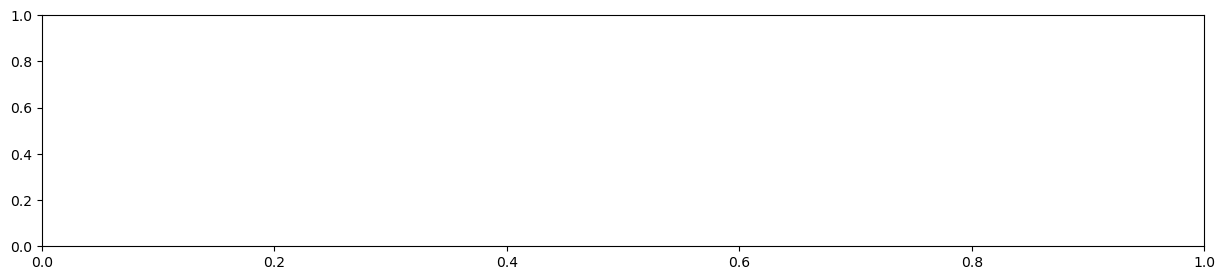

In [16]:
fig, ax = plt.subplots(1,1,figsize = (15,3))

#ax.scatter(valid_timestamps[0],1)

for a_ind in range(artifact_removed_time_list[0].shape[0]):
    #ax.axvline(artifact_removed_time_list[0][a_ind][0],color = 'g',linewidth = 1)
    ax.axvspan(artifact_removed_time_list[0][a_ind][0],artifact_removed_time_list[0][a_ind][1],color = 'k',linewidth = 1,alpha = 0.5)

ax.set_xlim(trial_1_t-100,trial_last_t+100)

In [169]:
artifact_time_list=interval_union(artifact_time_list[0],artifact_time_list[1])
artifact_removed_time_list=interval_list_intersect(
            np.array(artifact_removed_time_list[0]),np.array(artifact_removed_time_list[1]))

In [170]:
#artifact_removed_time_list

In [171]:
#artifact_removed_time_list

(1691786157.8352175, 1691787077.2597272)

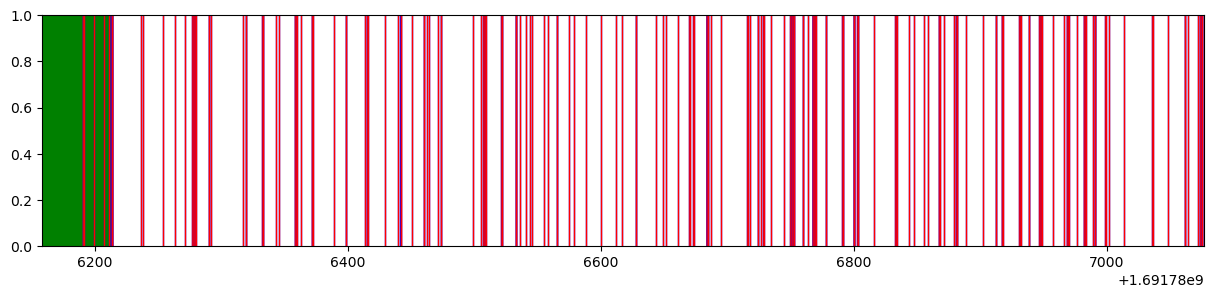

In [172]:
fig, ax = plt.subplots(1,1,figsize = (15,3))
for a_ind in range(artifact_time_list.shape[0]):
    ax.axvline(artifact_time_list[a_ind][0],color = 'b',linewidth = 1)
    ax.axvline(artifact_time_list[a_ind][1],color = 'r',linewidth = 1)
    #print(np.diff(artifact_time_list[a_ind]))

for a_ind in range(artifact_removed_time_list.shape[0]):
    ax.axvspan(artifact_removed_time_list[a_ind][0],artifact_removed_time_list[a_ind][1],color = 'g',linewidth = 1)

ax.set_xlim(trial_1_t,trial_last_t)

In [83]:
artifact_removed_time_list[-1][-1]

1691786212.2954159

In [75]:
test = interval_list_intersect(artifact_removed_time_list,np.array([trial_1_t,trial_last_t]))

In [82]:
test[-1][-1]

1691786212.2954159

In [48]:
artifact_removed_valid_times = (ArtifactRemovedIntervalList & {
    'artifact_removed_interval_list_name':
    'Julio20230811_.nwb_06_Seq2Session3_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}
).fetch1("artifact_removed_valid_times")

In [50]:
artifact_removed_valid_times[-1][-1]

1691786212.2954159

In [69]:
artifact_time_list[-1][0]

1691787094.6425176

In [51]:
int(marks.time[-1])

1691786212

In [54]:
position_df.index[-10]

1691787077.2412632

In [57]:
trial_last_t

1691787077.2597272

In [47]:
e = 0

In [51]:
positionIntervalList = (
        IntervalList &
        {'nwb_file_name': nwb_copy_file_name,
         'interval_list_name': position_interval[e]})

marks_selection = ((UnitMarks & mark_parameters_keys) * positionIntervalList)
marks_selection = (pd.DataFrame(marks_selection)
                   .loc[:, marks_selection.primary_key]
                   .to_dict('records'))
#UnitMarksIndicatorSelection.insert(marks_selection, skip_duplicates=True)

In [21]:
UnitMarksIndicatorSelection() & {'nwb_file_name': nwb_copy_file_name,
         'interval_list_name': position_interval[e]}

curation_id a number correponding to the index of this curation,nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,sorter,sorter_params_name,artifact_removed_interval_list_name,mark_param_name a name for this set of parameters,interval_list_name descriptive name of this interval list,sampling_rate
0,Julio20230811_.nwb,2,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0
0,Julio20230811_.nwb,3,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_3_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0
0,Julio20230811_.nwb,6,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_6_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0
0,Julio20230811_.nwb,7,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_7_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0
0,Julio20230811_.nwb,8,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_8_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0
0,Julio20230811_.nwb,11,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_11_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0
0,Julio20230811_.nwb,12,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_12_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0
0,Julio20230811_.nwb,15,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_15_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0
0,Julio20230811_.nwb,20,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_20_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0
0,Julio20230811_.nwb,22,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_22_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0


In [22]:
UnitMarksIndicator.populate(marks_selection)

[20:07:06][INFO] Spyglass: Writing new NWB file Julio20230811_GQ1JYSFHFJ.nwb
20-Apr-25 20:07:06 Writing new NWB file Julio20230811_GQ1JYSFHFJ.nwb
[20:07:09][INFO] Spyglass: Writing new NWB file Julio20230811_ET4QYAPL8C.nwb
20-Apr-25 20:07:09 Writing new NWB file Julio20230811_ET4QYAPL8C.nwb
[20:07:12][INFO] Spyglass: Writing new NWB file Julio20230811_K2LVYK4E0Z.nwb
20-Apr-25 20:07:12 Writing new NWB file Julio20230811_K2LVYK4E0Z.nwb
[20:07:14][INFO] Spyglass: Writing new NWB file Julio20230811_B40H72ADKA.nwb
20-Apr-25 20:07:14 Writing new NWB file Julio20230811_B40H72ADKA.nwb
[20:07:17][INFO] Spyglass: Writing new NWB file Julio20230811_0DBT4AZOLS.nwb
20-Apr-25 20:07:17 Writing new NWB file Julio20230811_0DBT4AZOLS.nwb
[20:07:19][INFO] Spyglass: Writing new NWB file Julio20230811_JQ38MZTRT2.nwb
20-Apr-25 20:07:19 Writing new NWB file Julio20230811_JQ38MZTRT2.nwb
[20:07:22][INFO] Spyglass: Writing new NWB file Julio20230811_W3AHIS37PH.nwb
20-Apr-25 20:07:22 Writing new NWB file Julio20

In [52]:
marks = (UnitMarksIndicator & mark_parameters_keys).fetch_xarray()

After you get the marks, it is important to visualize them to make sure they look right. We can use the `plot_all_marks` method of UnitMarksIndicator to quickly plot each mark feature against the other for each electrode.

Here it is important to look for things that look overly correlated (strong diagonal on the off-diagonal plots) and for extreme amplitudes.

In [24]:
UnitMarksIndicator & {
    'nwb_file_name': nwb_copy_file_name  
}

curation_id a number correponding to the index of this curation,nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,sorter,sorter_params_name,artifact_removed_interval_list_name,mark_param_name a name for this set of parameters,interval_list_name descriptive name of this interval list,sampling_rate,analysis_file_name name of the file,marks_indicator_object_id
0,Julio20230811_.nwb,2,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0,Julio20230811_GQ1JYSFHFJ.nwb,ecfd4344-69c5-4419-8913-63a51b5b881a
0,Julio20230811_.nwb,3,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_3_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0,Julio20230811_ET4QYAPL8C.nwb,d815f0ce-5e5a-4c54-bd2f-7cdffa2a92c6
0,Julio20230811_.nwb,6,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_6_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0,Julio20230811_K2LVYK4E0Z.nwb,414532b9-35ee-426a-9034-a8cad32bf0bc
0,Julio20230811_.nwb,7,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_7_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0,Julio20230811_B40H72ADKA.nwb,c38787d0-6d15-45a0-a8a9-bac19c4b75bb
0,Julio20230811_.nwb,8,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_8_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0,Julio20230811_0DBT4AZOLS.nwb,8dffc59b-5784-4e78-acfe-670c167b8db8
0,Julio20230811_.nwb,11,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_11_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0,Julio20230811_JQ38MZTRT2.nwb,0f3028bc-03e3-4cb8-9b26-2686815861ab
0,Julio20230811_.nwb,12,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_12_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0,Julio20230811_W3AHIS37PH.nwb,5001d036-12c2-4968-8188-20e8a91c6ac8
0,Julio20230811_.nwb,15,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_15_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0,Julio20230811_GJ6NIQ3OKE.nwb,3a2cc2b3-466f-4ab9-91c6-d96c7f8a834e
0,Julio20230811_.nwb,20,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_20_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0,Julio20230811_JKNKADR8XS.nwb,38f67bd2-944c-4902-b5d2-202da30995f8
0,Julio20230811_.nwb,22,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_22_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0,Julio20230811_TTPWP55LL2.nwb,5a5c382e-d611-4617-b1bf-9116eea2cd6e


## 2. Position

After the marks look good, you'll need to load/populate the 2D position data. This comes from the `IntervalPositionInfo` table. See the position tutorial for more information. Note that we will need to upsample the position data (which is done here via the `default_decoding` parameters) to match the sampling frequency that we intend to decode in (2 ms time bins or 500 Hz sampling rate)

Next we populate/load the linearized position tables. Again refer to the linear position tutorials for more information.

In [53]:
position_df = (IntervalPositionInfo &
 {'nwb_file_name': nwb_copy_file_name,
  'interval_list_name': position_interval[e],
  'position_info_param_name': 'default_decoding'}
              ).fetch1_dataframe()

In [54]:
position_df

,head_position_x,head_position_y,head_orientation,head_velocity_x,head_velocity_y,head_speed
time,,,,,,
1.691778e+09,NaN,NaN,NaN,NaN,NaN,NaN
1.691778e+09,NaN,NaN,NaN,NaN,NaN,NaN
1.691778e+09,NaN,NaN,NaN,NaN,NaN,NaN
1.691778e+09,NaN,NaN,NaN,NaN,NaN,NaN
1.691778e+09,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
1.691780e+09,215.625,238.25,-1.325818,0.0,0.0,0.0
1.691780e+09,215.625,238.25,-1.325818,0.0,0.0,0.0
1.691780e+09,215.625,238.25,-1.325814,0.0,0.0,0.0


In [55]:
from spyglass.common.common_position import IntervalLinearizedPosition

linear_position_df = (IntervalLinearizedPosition() &
 {'nwb_file_name': nwb_copy_file_name,
  'interval_list_name': position_interval[e],
  'position_info_param_name': 'default_decoding'}
).fetch1_dataframe()

linear_position_df

[23:08:27][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
24-Apr-25 23:08:27 Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


,linear_position,track_segment_id,projected_x_position,projected_y_position
time,,,,
1.691778e+09,NaN,0,NaN,NaN
1.691778e+09,NaN,0,NaN,NaN
1.691778e+09,NaN,0,NaN,NaN
1.691778e+09,NaN,0,NaN,NaN
1.691778e+09,NaN,0,NaN,NaN
...,...,...,...,...
1.691780e+09,0.0,0,210.25,234.0
1.691780e+09,0.0,0,210.25,234.0
1.691780e+09,0.0,0,210.25,234.0


We should also quickly visualize the linear position in order to sanity check the values. Here we plot the 2D position projected to its corresponding 1D segment.

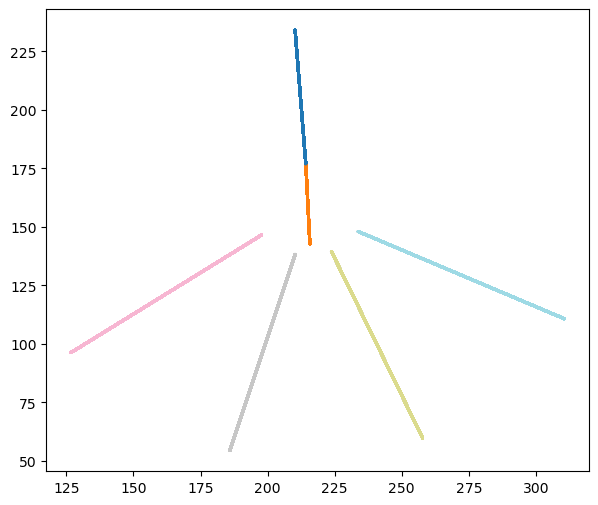

In [56]:
plt.figure(figsize=(7, 6))
plt.scatter(linear_position_df.projected_x_position, linear_position_df.projected_y_position,
            c=linear_position_df.track_segment_id, cmap='tab20', s=1)

We should also plot the linearized position itself to make sure it is okay.

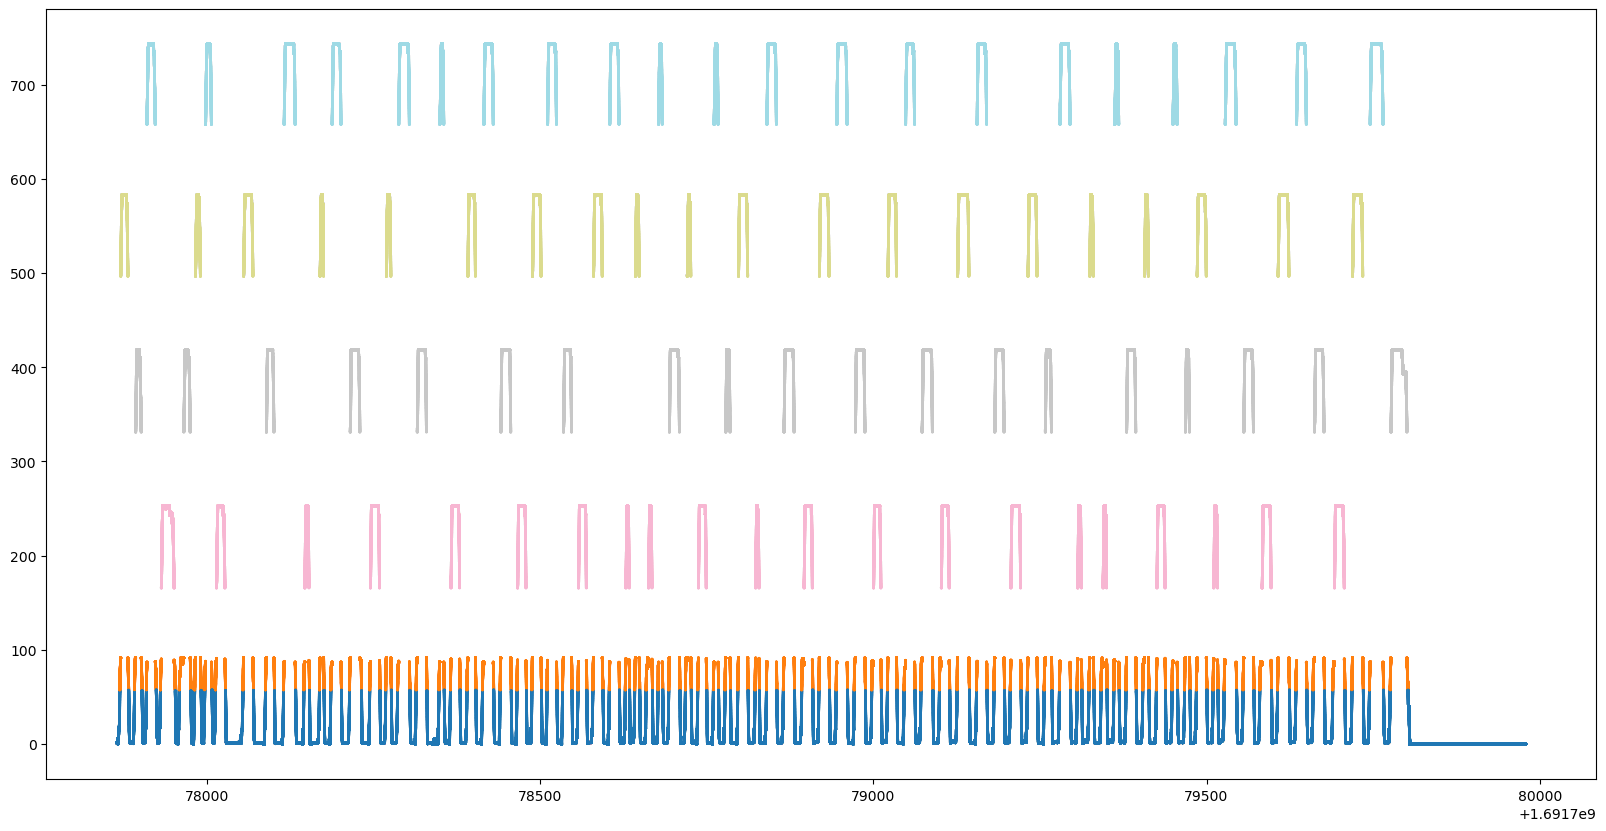

In [57]:
plt.figure(figsize=(20, 10))
plt.scatter(linear_position_df.index, linear_position_df.linear_position, s=1,
            c=linear_position_df.track_segment_id, cmap='tab20')

Okay now that we've looked at the data, we should quickly verify that all our data is the same size.

We also want to make sure we have valid ephys data and valid position data for decoding. Here we only have one valid time interval, but if we had more than one, we should decode on each interval separately.

In [58]:
intersect_interval = intersectValidIntervals(nwb_copy_file_name,
                                                session_interval[e],position_interval[e])
marks_=[]
linear_position_df_=[]
position_df_ =[]
for i in range(len(intersect_interval)):
    valid_time_slice = slice(intersect_interval[i][0], intersect_interval[i][1])
    
    linear_position_df_.append(linear_position_df.loc[valid_time_slice])
    position_df_.append(position_df.loc[valid_time_slice])
    marks_.append(marks.sel(time=valid_time_slice))

marks=xr.concat(marks_,dim='time')
position_df = pd.concat(position_df_)
linear_position_df=pd.concat(linear_position_df_)
marks.shape, position_df.shape, linear_position_df.shape

((952590, 4, 25), (952588, 6), (952588, 4))

In [64]:
animal = nwb_copy_file_name[:5]
marks_path=os.path.join(f'/cumulus/shijie/recording_pilot/{animal}/decoding',
                             nwb_copy_file_name+'_'+session_interval[e]+'_marks.nc')
marks.to_netcdf(marks_path, engine = "netcdf4")

In [44]:
1000/60

16.666666666666668

In [33]:
animal = nwb_copy_file_name[:5]
marks_path=os.path.join(f'/cumulus/shijie/recording_pilot/{animal}/decoding',
                             nwb_copy_file_name+'_'+session_interval[e]+'_marks.nc')
marks.to_netcdf(marks_path)

position1d_path=os.path.join(f'/cumulus/shijie/recording_pilot/{animal}/decoding',
                             nwb_copy_file_name+'_'+session_interval[e]+'_1dposition.csv')
linear_position_df.to_csv(position1d_path)

position2d_path=os.path.join(f'/cumulus/shijie/recording_pilot/{animal}/decoding',
                             nwb_copy_file_name+'_'+session_interval[e]+'_2dposition.csv')
position_df.to_csv(position2d_path)

In [34]:
from spyglass.shijiegu.Analysis_SGU import DecodeIngredients
key={'nwb_file_name':nwb_copy_file_name,
     'interval_list_name':session_interval[e],
     'marks':marks_path,
     'position_1d':position1d_path,
     'position_2d':position2d_path}
DecodeIngredients().insert1(key,replace=True)

In [29]:
from spyglass.shijiegu.Analysis_SGU import DecodeIngredients
DecodeIngredients() & {'nwb_file_name':nwb_copy_file_name}

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,marks valid marks within that interval,"position_1d valid position within that interval (1D), inluding all rat-on-track time","position_2d valid position within that interval (2D), inluding all rat-on-track time"
klein20231111_.nwb,02_Rev2Session1,=BLOB=,=BLOB=,=BLOB=
klein20231111_.nwb,04_Rev2Session2,=BLOB=,=BLOB=,=BLOB=
klein20231111_.nwb,06_Rev2Session3,=BLOB=,=BLOB=,=BLOB=
klein20231111_.nwb,08_Rev2Session4,=BLOB=,=BLOB=,=BLOB=
klein20231111_.nwb,10_Rev2Session5,=BLOB=,=BLOB=,=BLOB=


In [87]:
%debug

> /home/shijiegu/Documents/spyglass/src/spyglass/shijiegu/decodeHelpers.py(153)decodePrepMasterSession()
    151             assert len(linear_position_df_tmp) == marks_tmp.shape[0]
    152             assert linear_position_df_tmp.index[0] - float(marks_tmp.time[0]) <= 0.003
--> 153             assert linear_position_df_tmp.index[-1] - float(marks_tmp.time[-1]) <= 0.003
    154 
    155             linear_position_df_.append(linear_position_df_tmp)



ipdb>  linear_position_df_tmp.index[-1] - float(marks_tmp.time[-1])


0.0031299591064453125


ipdb>  exit


# Run All sessions

In [25]:
session_interval, position_interval = runSessionNames(nwb_copy_file_name)
print(nwb_copy_file_name)
print(session_interval)

klein20231111_.nwb
['02_Rev2Session1', '04_Rev2Session2', '06_Rev2Session3', '08_Rev2Session4', '10_Rev2Session5']


In [26]:
sleep_interval, sleep_position_interval = sleepSessionNames(nwb_copy_file_name)
print(nwb_copy_file_name)
print(sleep_interval)

klein20231111_.nwb
['01_Rev2Sleep1', '03_Rev2Sleep2', '05_Rev2Sleep3', '07_Rev2Sleep4', '09_Rev2Sleep5', '11_Rev2Sleep6']


In [27]:
#%debug

In [ ]:
for e in session_interval:
    decodePrepMasterSession(nwb_copy_file_name,e,populate = True)

0
inserting into IntervalList
done inserting into IntervalList
8
inserting into IntervalList
done inserting into IntervalList
10
inserting into IntervalList
done inserting into IntervalList
11
inserting into IntervalList
done inserting into IntervalList
12
inserting into IntervalList
done inserting into IntervalList
15
inserting into IntervalList
done inserting into IntervalList
16
inserting into IntervalList
done inserting into IntervalList
28
inserting into IntervalList
done inserting into IntervalList
30
inserting into IntervalList
done inserting into IntervalList
36
inserting into IntervalList
done inserting into IntervalList
45
inserting into IntervalList
done inserting into IntervalList
52
inserting into IntervalList
done inserting into IntervalList
53
inserting into IntervalList
done inserting into IntervalList
54
inserting into IntervalList
done inserting into IntervalList
63
inserting into IntervalList
done inserting into IntervalList


[12:50:49][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'klein20231111_.nwb', 'sort_group_id': 0, 'sort_interval_name': '02_Rev2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'klein20231111_.nwb_02_Rev2Session1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
14-Jun-25 12:50:49 Running spike sorting on {'nwb_file_name': 'klein20231111_.nwb', 'sort_group_id': 0, 'sort_interval_name': '02_Rev2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'klein20231111_.nwb_02_Rev2Session1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...


detect peaks using locally_exclusive:   0%|          | 0/3068 [00:00<?, ?it/s]

[12:51:00][INFO] Spyglass: Saving sorting results...
14-Jun-25 12:51:00 Saving sorting results...
[12:51:07][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'klein20231111_.nwb', 'sort_group_id': 10, 'sort_interval_name': '02_Rev2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'klein20231111_.nwb_02_Rev2Session1_10_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
14-Jun-25 12:51:07 Running spike sorting on {'nwb_file_name': 'klein20231111_.nwb', 'sort_group_id': 10, 'sort_interval_name': '02_Rev2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'klein20231111_.nwb_02_Rev2Session1_10_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/3068 [00:00<?, ?it/s]

[12:51:16][INFO] Spyglass: Saving sorting results...
14-Jun-25 12:51:16 Saving sorting results...
[12:51:24][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'klein20231111_.nwb', 'sort_group_id': 11, 'sort_interval_name': '02_Rev2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'klein20231111_.nwb_02_Rev2Session1_11_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
14-Jun-25 12:51:24 Running spike sorting on {'nwb_file_name': 'klein20231111_.nwb', 'sort_group_id': 11, 'sort_interval_name': '02_Rev2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'klein20231111_.nwb_02_Rev2Session1_11_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/3068 [00:00<?, ?it/s]

[12:51:35][INFO] Spyglass: Saving sorting results...
14-Jun-25 12:51:35 Saving sorting results...
[12:51:44][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'klein20231111_.nwb', 'sort_group_id': 12, 'sort_interval_name': '02_Rev2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'klein20231111_.nwb_02_Rev2Session1_12_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
14-Jun-25 12:51:44 Running spike sorting on {'nwb_file_name': 'klein20231111_.nwb', 'sort_group_id': 12, 'sort_interval_name': '02_Rev2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'klein20231111_.nwb_02_Rev2Session1_12_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/3068 [00:00<?, ?it/s]

[12:51:53][INFO] Spyglass: Saving sorting results...
14-Jun-25 12:51:53 Saving sorting results...
[12:52:02][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'klein20231111_.nwb', 'sort_group_id': 15, 'sort_interval_name': '02_Rev2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'klein20231111_.nwb_02_Rev2Session1_15_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
14-Jun-25 12:52:02 Running spike sorting on {'nwb_file_name': 'klein20231111_.nwb', 'sort_group_id': 15, 'sort_interval_name': '02_Rev2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'klein20231111_.nwb_02_Rev2Session1_15_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/3068 [00:00<?, ?it/s]

[12:52:13][INFO] Spyglass: Saving sorting results...
14-Jun-25 12:52:13 Saving sorting results...
[12:52:17][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'klein20231111_.nwb', 'sort_group_id': 16, 'sort_interval_name': '02_Rev2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'klein20231111_.nwb_02_Rev2Session1_16_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
14-Jun-25 12:52:17 Running spike sorting on {'nwb_file_name': 'klein20231111_.nwb', 'sort_group_id': 16, 'sort_interval_name': '02_Rev2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'klein20231111_.nwb_02_Rev2Session1_16_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/3068 [00:00<?, ?it/s]

[12:52:29][INFO] Spyglass: Saving sorting results...
14-Jun-25 12:52:29 Saving sorting results...
[12:52:32][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'klein20231111_.nwb', 'sort_group_id': 28, 'sort_interval_name': '02_Rev2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'klein20231111_.nwb_02_Rev2Session1_28_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
14-Jun-25 12:52:32 Running spike sorting on {'nwb_file_name': 'klein20231111_.nwb', 'sort_group_id': 28, 'sort_interval_name': '02_Rev2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'klein20231111_.nwb_02_Rev2Session1_28_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/3068 [00:00<?, ?it/s]

[12:52:43][INFO] Spyglass: Saving sorting results...
14-Jun-25 12:52:43 Saving sorting results...
[12:52:46][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'klein20231111_.nwb', 'sort_group_id': 30, 'sort_interval_name': '02_Rev2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'klein20231111_.nwb_02_Rev2Session1_30_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
14-Jun-25 12:52:46 Running spike sorting on {'nwb_file_name': 'klein20231111_.nwb', 'sort_group_id': 30, 'sort_interval_name': '02_Rev2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'klein20231111_.nwb_02_Rev2Session1_30_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/3068 [00:00<?, ?it/s]

[12:52:57][INFO] Spyglass: Saving sorting results...
14-Jun-25 12:52:57 Saving sorting results...
[12:53:00][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'klein20231111_.nwb', 'sort_group_id': 36, 'sort_interval_name': '02_Rev2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'klein20231111_.nwb_02_Rev2Session1_36_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
14-Jun-25 12:53:00 Running spike sorting on {'nwb_file_name': 'klein20231111_.nwb', 'sort_group_id': 36, 'sort_interval_name': '02_Rev2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'klein20231111_.nwb_02_Rev2Session1_36_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/3068 [00:00<?, ?it/s]

[12:53:13][INFO] Spyglass: Saving sorting results...
14-Jun-25 12:53:13 Saving sorting results...
[12:53:16][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'klein20231111_.nwb', 'sort_group_id': 45, 'sort_interval_name': '02_Rev2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'klein20231111_.nwb_02_Rev2Session1_45_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
14-Jun-25 12:53:16 Running spike sorting on {'nwb_file_name': 'klein20231111_.nwb', 'sort_group_id': 45, 'sort_interval_name': '02_Rev2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'klein20231111_.nwb_02_Rev2Session1_45_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/3068 [00:00<?, ?it/s]

[12:53:27][INFO] Spyglass: Saving sorting results...
14-Jun-25 12:53:27 Saving sorting results...
[12:53:31][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'klein20231111_.nwb', 'sort_group_id': 52, 'sort_interval_name': '02_Rev2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'klein20231111_.nwb_02_Rev2Session1_52_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
14-Jun-25 12:53:31 Running spike sorting on {'nwb_file_name': 'klein20231111_.nwb', 'sort_group_id': 52, 'sort_interval_name': '02_Rev2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'klein20231111_.nwb_02_Rev2Session1_52_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/3068 [00:00<?, ?it/s]

[12:53:41][INFO] Spyglass: Saving sorting results...
14-Jun-25 12:53:41 Saving sorting results...
[12:53:45][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'klein20231111_.nwb', 'sort_group_id': 53, 'sort_interval_name': '02_Rev2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'klein20231111_.nwb_02_Rev2Session1_53_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
14-Jun-25 12:53:45 Running spike sorting on {'nwb_file_name': 'klein20231111_.nwb', 'sort_group_id': 53, 'sort_interval_name': '02_Rev2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'klein20231111_.nwb_02_Rev2Session1_53_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/3068 [00:00<?, ?it/s]

[12:53:55][INFO] Spyglass: Saving sorting results...
14-Jun-25 12:53:55 Saving sorting results...
[12:53:58][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'klein20231111_.nwb', 'sort_group_id': 54, 'sort_interval_name': '02_Rev2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'klein20231111_.nwb_02_Rev2Session1_54_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
14-Jun-25 12:53:58 Running spike sorting on {'nwb_file_name': 'klein20231111_.nwb', 'sort_group_id': 54, 'sort_interval_name': '02_Rev2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'klein20231111_.nwb_02_Rev2Session1_54_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/3068 [00:00<?, ?it/s]

[12:54:07][INFO] Spyglass: Saving sorting results...
14-Jun-25 12:54:07 Saving sorting results...
[12:54:11][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'klein20231111_.nwb', 'sort_group_id': 63, 'sort_interval_name': '02_Rev2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'klein20231111_.nwb_02_Rev2Session1_63_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
14-Jun-25 12:54:11 Running spike sorting on {'nwb_file_name': 'klein20231111_.nwb', 'sort_group_id': 63, 'sort_interval_name': '02_Rev2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'klein20231111_.nwb_02_Rev2Session1_63_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/3068 [00:00<?, ?it/s]

[12:54:22][INFO] Spyglass: Saving sorting results...
14-Jun-25 12:54:22 Saving sorting results...
[12:54:33][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'klein20231111_.nwb', 'sort_group_id': 8, 'sort_interval_name': '02_Rev2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'klein20231111_.nwb_02_Rev2Session1_8_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
14-Jun-25 12:54:33 Running spike sorting on {'nwb_file_name': 'klein20231111_.nwb', 'sort_group_id': 8, 'sort_interval_name': '02_Rev2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'klein20231111_.nwb_02_Rev2Session1_8_franklab_tetrode_hippocampus_ampl_1500_p

detect peaks using locally_exclusive:   0%|          | 0/3068 [00:00<?, ?it/s]

[12:54:45][INFO] Spyglass: Saving sorting results...
14-Jun-25 12:54:45 Saving sorting results...
[12:54:46][WARNING] Spyglass: Turning off transaction protection this table by default. Use use_transation=True to re-enable.
Read more about transactions:
https://docs.datajoint.io/python/definition/05-Transactions.html
https://github.com/LorenFrankLab/spyglass/issues/1030
14-Jun-25 12:54:46 Turning off transaction protection this table by default. Use use_transation=True to re-enable.
Read more about transactions:
https://docs.datajoint.io/python/definition/05-Transactions.html
https://github.com/LorenFrankLab/spyglass/issues/1030
[2025-06-14 12:54:50,344][WARNING]: Skipped checksum for file with hash: ecb885f0-f8b8-075c-38fe-d46f5518d325, and path: /stelmo/nwb/raw/klein20231111_.nwb
14-Jun-25 12:54:50 Skipped checksum for file with hash: ecb885f0-f8b8-075c-38fe-d46f5518d325, and path: /stelmo/nwb/raw/klein20231111_.nwb
[12:54:51][WARNING] Spyglass: Metrics for Curation {'curation_id': 0

extract waveforms shared_memory multi buffer:   0%|          | 0/1 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/pynwb/behavior.py:48: UserWarning: SpatialSeries 'series_0' has data shape (44222, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/pynwb/behavior.py:48: UserWarning: SpatialSeries 'series_1' has data shape (75048, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/pynwb/behavior.py:48: UserWarning: SpatialSeries 'series_10' has data shape (14355, 6) which is not compliant with NWB 2.5 and greater. The second dimension should ha

extract waveforms shared_memory multi buffer:   0%|          | 0/1 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/pynwb/behavior.py:48: UserWarning: SpatialSeries 'series_0' has data shape (44222, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/pynwb/behavior.py:48: UserWarning: SpatialSeries 'series_1' has data shape (75048, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/pynwb/behavior.py:48: UserWarning: SpatialSeries 'series_10' has data shape (14355, 6) which is not compliant with NWB 2.5 and greater. The second dimension should ha

extract waveforms shared_memory multi buffer:   0%|          | 0/1 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/pynwb/behavior.py:48: UserWarning: SpatialSeries 'series_0' has data shape (44222, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/pynwb/behavior.py:48: UserWarning: SpatialSeries 'series_1' has data shape (75048, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/pynwb/behavior.py:48: UserWarning: SpatialSeries 'series_10' has data shape (14355, 6) which is not compliant with NWB 2.5 and greater. The second dimension should ha

extract waveforms shared_memory multi buffer:   0%|          | 0/1 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/pynwb/behavior.py:48: UserWarning: SpatialSeries 'series_0' has data shape (44222, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/pynwb/behavior.py:48: UserWarning: SpatialSeries 'series_1' has data shape (75048, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/pynwb/behavior.py:48: UserWarning: SpatialSeries 'series_10' has data shape (14355, 6) which is not compliant with NWB 2.5 and greater. The second dimension should ha

extract waveforms shared_memory multi buffer:   0%|          | 0/1 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/pynwb/behavior.py:48: UserWarning: SpatialSeries 'series_0' has data shape (44222, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/pynwb/behavior.py:48: UserWarning: SpatialSeries 'series_1' has data shape (75048, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/pynwb/behavior.py:48: UserWarning: SpatialSeries 'series_10' has data shape (14355, 6) which is not compliant with NWB 2.5 and greater. The second dimension should ha

extract waveforms shared_memory multi buffer:   0%|          | 0/1 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/pynwb/behavior.py:48: UserWarning: SpatialSeries 'series_0' has data shape (44222, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/pynwb/behavior.py:48: UserWarning: SpatialSeries 'series_1' has data shape (75048, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/pynwb/behavior.py:48: UserWarning: SpatialSeries 'series_10' has data shape (14355, 6) which is not compliant with NWB 2.5 and greater. The second dimension should ha

extract waveforms shared_memory multi buffer:   0%|          | 0/1 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/pynwb/behavior.py:48: UserWarning: SpatialSeries 'series_0' has data shape (44222, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/pynwb/behavior.py:48: UserWarning: SpatialSeries 'series_1' has data shape (75048, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/pynwb/behavior.py:48: UserWarning: SpatialSeries 'series_10' has data shape (14355, 6) which is not compliant with NWB 2.5 and greater. The second dimension should ha

extract waveforms shared_memory multi buffer:   0%|          | 0/1 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/pynwb/behavior.py:48: UserWarning: SpatialSeries 'series_0' has data shape (44222, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/pynwb/behavior.py:48: UserWarning: SpatialSeries 'series_1' has data shape (75048, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/pynwb/behavior.py:48: UserWarning: SpatialSeries 'series_10' has data shape (14355, 6) which is not compliant with NWB 2.5 and greater. The second dimension should ha

extract waveforms shared_memory multi buffer:   0%|          | 0/1 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/pynwb/behavior.py:48: UserWarning: SpatialSeries 'series_0' has data shape (44222, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/pynwb/behavior.py:48: UserWarning: SpatialSeries 'series_1' has data shape (75048, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/pynwb/behavior.py:48: UserWarning: SpatialSeries 'series_10' has data shape (14355, 6) which is not compliant with NWB 2.5 and greater. The second dimension should ha

extract waveforms shared_memory multi buffer:   0%|          | 0/1 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/pynwb/behavior.py:48: UserWarning: SpatialSeries 'series_0' has data shape (44222, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/pynwb/behavior.py:48: UserWarning: SpatialSeries 'series_1' has data shape (75048, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/pynwb/behavior.py:48: UserWarning: SpatialSeries 'series_10' has data shape (14355, 6) which is not compliant with NWB 2.5 and greater. The second dimension should ha

extract waveforms shared_memory multi buffer:   0%|          | 0/1 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/pynwb/behavior.py:48: UserWarning: SpatialSeries 'series_0' has data shape (44222, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/pynwb/behavior.py:48: UserWarning: SpatialSeries 'series_1' has data shape (75048, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/pynwb/behavior.py:48: UserWarning: SpatialSeries 'series_10' has data shape (14355, 6) which is not compliant with NWB 2.5 and greater. The second dimension should ha

In [55]:
%debug

> /home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/utils.py(569)_check_args()
    567                 if parse_err:
    568                     msg = '%s: %s' % (func.__qualname__, ', '.join(parse_err))
--> 569                     raise ExceptionType(msg)
    570 
    571             return parsed['args']



ipdb>  u


> /home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/utils.py(576)func_call()
    574         if is_method:
    575             def func_call(*args, **kwargs):
--> 576                 pargs = _check_args(args, kwargs)
    577                 return func(args[0], **pargs)
    578         else:



ipdb>  u


> /home/shijiegu/Documents/spyglass/src/spyglass/common/common_nwbfile.py(472)add_units()
    470             # Add spike times and valid time range for the sort
    471             for id in units.keys():
--> 472                 nwbf.add_unit(
    473                     spike_times=units[id],
    474                     id=id,



ipdb>  len(units[id])


7365


ipdb>  len(units_valid_times[id])


0


ipdb>  id


0


ipdb>  units_valid_times


{0: []}


ipdb>  u


> /home/shijiegu/Documents/spyglass/src/spyglass/spikesorting/v0/spikesorting_curation.py(259)save_sorting_nwb()
    257             units_sort_interval[unit_id] = [sort_interval]
    258 
--> 259         object_ids = AnalysisNwbfile().add_units(
    260             analysis_file_name,
    261             units,



ipdb>  sort_interval


array([[1.69083364e+09, 1.69083540e+09]])


ipdb>  sort_interval[0][0]


1690833636.0719533


ipdb>  sort_interval[0][1]


1690835403.741607


ipdb>  sort_interval_valid_times


[]


ipdb>  sort_interval_list_name


'julio20230731_.nwb_06_Seq2Session3_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'


ipdb>  exit


In [ ]:
{'curation_id': 0, 'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 2, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_02_Seq2Session1_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only', 'mark_param_name': 'default', 'analysis_file_name': 'Julio20230811_KD6PZ2J00L.nwb'}

In [75]:
(IntervalList() & {'interval_list_name':
                'julio20230731_.nwb_06_Seq2Session3_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'
               }).delete()

[21:24:41][INFO] Spyglass: Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
26-May-25 21:24:41 Path Found : ['`common_session`.`_session`', '`common_interval`.`interval_list`'...
[21:24:41][INFO] Spyglass: Checking  0: IntervalList -> ['Session']
26-May-25 21:24:41 Checking  0: IntervalList -> ['Session']
[21:24:41][INFO] Spyglass: Bridge Link: IntervalList -> Session: result partial
26-May-25 21:24:41 Bridge Link: IntervalList -> Session: result partial
[21:24:41][INFO] Spyglass: Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
26-May-25 21:24:41 Checking  1: Session -> ['Nwbfile', 'Subject', 'Institution', 'Lab', 'SessionDat...
[21:24:41][INFO] Spyglass: Banned Tbl : Nwbfile
26-May-25 21:24:41 Banned Tbl : Nwbfile
[21:24:41][INFO] Spyglass: Banned Tbl : Subject
26-May-25 21:24:41 Banned Tbl : Subject
[21:24:41][INFO] Spyglass: Banned Tbl : Institution
26-May-25 21:24:41 Banned Tbl : Institution
[21:24:41][INFO] Spy

Commit deletes? [yes, No]:  yes


[2025-05-26 21:24:44,578][INFO]: Deletes committed.
26-May-25 21:24:44 Deletes committed.


In [68]:
%debug

> /home/shijiegu/Documents/spyglass/notebooks/DataPreprocessing/src/netCDF4/_netCDF4.pyx(2158)netCDF4._netCDF4._ensure_nc_success()



ipdb>  u


> /home/shijiegu/Documents/spyglass/notebooks/DataPreprocessing/src/netCDF4/_netCDF4.pyx(2521)netCDF4._netCDF4.Dataset.__init__()



ipdb>  u


> /home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/xarray/backends/file_manager.py(217)_acquire_with_cache_info()
    215                     kwargs = kwargs.copy()
    216                     kwargs["mode"] = self._mode
--> 217                 file = self._opener(*self._args, **kwargs)
    218                 if self._mode == "w":
    219                     # ensure file doesn't get overridden when opened again



ipdb>  u


> /home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/xarray/backends/file_manager.py(199)acquire_context()
    197     def acquire_context(self, needs_lock=True):
    198         """Context manager for acquiring a file."""
--> 199         file, cached = self._acquire_with_cache_info(needs_lock)
    200         try:
    201             yield file



ipdb>  u


> /home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/contextlib.py(135)__enter__()
    133         del self.args, self.kwds, self.func
    134         try:
--> 135             return next(self.gen)
    136         except StopIteration:
    137             raise RuntimeError("generator didn't yield") from None



ipdb>  u


> /home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/xarray/backends/netCDF4_.py(412)_acquire()
    410 
    411     def _acquire(self, needs_lock=True):
--> 412         with self._manager.acquire_context(needs_lock) as root:
    413             ds = _nc4_require_group(root, self._group, self._mode)
    414         return ds



ipdb>  u


> /home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/xarray/backends/netCDF4_.py(418)ds()
    416     @property
    417     def ds(self):
--> 418         return self._acquire()
    419 
    420     def open_store_variable(self, name: str, var):



ipdb>  u


> /home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/xarray/backends/netCDF4_.py(356)__init__()
    354         self._group = group
    355         self._mode = mode
--> 356         self.format = self.ds.data_model
    357         self._filename = self.ds.filepath()
    358         self.is_remote = is_remote_uri(self._filename)



ipdb>  u


> /home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/xarray/backends/netCDF4_.py(409)open()
    407             netCDF4.Dataset, filename, mode=mode, kwargs=kwargs
    408         )
--> 409         return cls(manager, group=group, mode=mode, lock=lock, autoclose=autoclose)
    410 
    411     def _acquire(self, needs_lock=True):



ipdb>  u


> /home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/xarray/backends/api.py(1322)to_netcdf()
   1320                 f"unrecognized option 'invalid_netcdf' for engine {engine}"
   1321             )
-> 1322     store = store_open(target, mode, format, group, **kwargs)
   1323 
   1324     if unlimited_dims is None:



ipdb>  u


> /home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/xarray/core/dataarray.py(4095)to_netcdf()
   4093             dataset = self.to_dataset()
   4094 
-> 4095         return to_netcdf(  # type: ignore  # mypy cannot resolve the overloads:(
   4096             dataset,
   4097             path,



ipdb>  u


> /home/shijiegu/Documents/spyglass/src/spyglass/shijiegu/decodeHelpers.py(170)decodePrepMasterSession()
    168     marks_path=os.path.join(f'/cumulus/shijie/recording_pilot/{animal}/decoding',
    169                              nwb_copy_file_name+'_'+session_name+'_marks.nc')
--> 170     marks.to_netcdf(marks_path, engine = "netcdf4")
    171 
    172     position1d_path=os.path.join(f'/cumulus/shijie/recording_pilot/{animal}/decoding',



ipdb>  marks_path


'/cumulus/shijie/recording_pilot/klein/decoding/klein20231105_.nwb_02_Rev2Session1_marks.nc'


ipdb>  exity


*** NameError: name 'exity' is not defined


ipdb>  exit


In [21]:
%debug

> /home/shijiegu/Documents/spyglass/src/spyglass/decoding/v0/clusterless.py(187)make()
    185 
    186         # retrieve the units from the NWB file
--> 187         nwb_units = (CuratedSpikeSorting() & key).fetch_nwb()[0]["units"]
    188 
    189         recording = Curation.get_recording(key)



ipdb>  key


{'curation_id': 0, 'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 2, 'sort_interval_name': '02_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_02_Seq2Session1_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only', 'mark_param_name': 'default', 'analysis_file_name': 'Julio20230811_KD6PZ2J00L.nwb'}


ipdb>  (CuratedSpikeSorting() & key)


*curation_id   *nwb_file_name *sort_group_id *sort_interval *preproc_param *team_name    *sorter    *sorter_params *artifact_remo analysis_file_ units_object_i
+------------+ +------------+ +------------+ +------------+ +------------+ +-----------+ +--------+ +------------+ +------------+ +------------+ +------------+

 (Total: 0)



ipdb>  CuratedSpikeSorting() & {'curation_id': 0, 'nwb_file_name': 'Julio20230811_.nwb'}


*curation_id   *nwb_file_name *sort_group_id *sort_interval *preproc_param *team_name     *sorter        *sorter_params *artifact_remo analysis_file_ units_object_i
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+
0              Julio20230811_ 2              02_Seq2Session franklab_tetro SequenceTask   clusterless_th default        Julio20230811_ Julio20230811_ 953b70d8-0bf2-
0              Julio20230811_ 3              02_Seq2Session franklab_tetro SequenceTask   clusterless_th default        Julio20230811_ Julio20230811_ e1db7537-84b3-
0              Julio20230811_ 6              02_Seq2Session franklab_tetro SequenceTask   clusterless_th default        Julio20230811_ Julio20230811_ d4433c65-dabc-
0              Julio20230811_ 7              02_Seq2Session franklab_tetro SequenceTask   clusterless_th default        Julio20230811_ Julio20230811_ 015f70e8-ec5b-
0         

ipdb>  exit


In [ ]:
ArtifactDetectionSelection & {}

In [14]:
%debug

> /home/shijiegu/Documents/spyglass/src/spyglass/common/common_interval.py(299)_intersection()
    297 def _intersection(interval1, interval2):
    298     """Takes the (set-theoretic) intersection of two intervals"""
--> 299     start = max(interval1[0], interval2[0])
    300     end = min(interval1[1], interval2[1])
    301     intersection = np.array([start, end]) if end > start else None



ipdb>  interval2


array([], dtype=float64)


ipdb>  interval1


array([1.65022621e+09, 1.65022823e+09])


ipdb>  up


> /home/shijiegu/Documents/spyglass/src/spyglass/common/common_interval.py(282)<listcomp>()
    280         for interval2 in interval_list2
    281         for interval1 in interval_list1
--> 282         if _intersection(interval2, interval1) is not None
    283     ]
    284 



ipdb>  u


> /home/shijiegu/Documents/spyglass/src/spyglass/common/common_interval.py(278)interval_list_intersect()
    276 
    277     # then do pairwise comparison and collect intersections
--> 278     intersecting_intervals = [
    279         _intersection(interval2, interval1)
    280         for interval2 in interval_list2



ipdb>  u


> /home/shijiegu/Documents/spyglass/src/spyglass/shijiegu/decodeHelpers.py(228)thresholder_sort()
    226         trial_last_t = StateScript.loc[len(StateScript)-1].timestamp_O
    227 
--> 228         artifact_removed_time_list=interval_list_intersect(artifact_removed_time_list,np.array([trial_1_t,trial_last_t]))
    229     else:
    230         artifact_removed_time_list = artifact_removed_time_list.reshape((-1,2))



ipdb>  np.array([trial_1_t,trial_last_t]


*** SyntaxError: unexpected EOF while parsing


ipdb>  np.array([trial_1_t,trial_last_t])


array([1.65022621e+09, 1.65022823e+09])


ipdb>  artifact_removed_time_list


array([], dtype=float64)


ipdb>  exit


In [32]:
ArtifactDetectionSelection

spyglass.spikesorting.v0.spikesorting_artifact.ArtifactDetectionSelection

In [80]:
for e in sleep_interval:
    thresholder_sort(nwb_copy_file_name,e,True)

2
inserting into IntervalList
done inserting into IntervalList
3
inserting into IntervalList
done inserting into IntervalList
6
inserting into IntervalList
done inserting into IntervalList
7
inserting into IntervalList
done inserting into IntervalList
8
inserting into IntervalList
done inserting into IntervalList
11
inserting into IntervalList
done inserting into IntervalList
12
inserting into IntervalList
done inserting into IntervalList
15
inserting into IntervalList
done inserting into IntervalList
20
inserting into IntervalList
done inserting into IntervalList
22
inserting into IntervalList
done inserting into IntervalList
26
inserting into IntervalList
done inserting into IntervalList
28
inserting into IntervalList
done inserting into IntervalList
29
inserting into IntervalList
done inserting into IntervalList
30
inserting into IntervalList
done inserting into IntervalList
31
inserting into IntervalList
done inserting into IntervalList
36
inserting into IntervalList
done inserting

[09:43:53][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 11, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_11_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:43:53 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 11, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_11_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...


detect peaks using locally_exclusive:   0%|          | 0/717 [00:00<?, ?it/s]

[09:43:58][INFO] Spyglass: Saving sorting results...
03-May-25 09:43:58 Saving sorting results...
[09:44:00][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 12, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_12_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:44:00 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 12, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_12_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/717 [00:00<?, ?it/s]

[09:44:02][INFO] Spyglass: Saving sorting results...
03-May-25 09:44:02 Saving sorting results...
[09:44:03][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 15, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_15_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:44:03 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 15, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_15_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/717 [00:00<?, ?it/s]

[09:44:06][INFO] Spyglass: Saving sorting results...
03-May-25 09:44:06 Saving sorting results...
[09:44:08][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 20, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_20_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:44:08 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 20, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_20_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/717 [00:00<?, ?it/s]

[09:44:10][INFO] Spyglass: Saving sorting results...
03-May-25 09:44:10 Saving sorting results...
[09:44:12][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 22, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_22_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:44:12 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 22, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_22_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/717 [00:00<?, ?it/s]

[09:44:14][INFO] Spyglass: Saving sorting results...
03-May-25 09:44:14 Saving sorting results...
[09:44:16][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 26, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_26_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:44:16 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 26, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_26_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/717 [00:00<?, ?it/s]

[09:44:18][INFO] Spyglass: Saving sorting results...
03-May-25 09:44:18 Saving sorting results...
[09:44:19][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 28, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_28_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:44:19 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 28, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_28_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/717 [00:00<?, ?it/s]

[09:44:21][INFO] Spyglass: Saving sorting results...
03-May-25 09:44:21 Saving sorting results...
[09:44:23][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 29, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_29_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:44:23 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 29, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_29_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/717 [00:00<?, ?it/s]

[09:44:24][INFO] Spyglass: Saving sorting results...
03-May-25 09:44:24 Saving sorting results...
[09:44:26][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 2, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:44:26 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 2, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/717 [00:00<?, ?it/s]

[09:44:28][INFO] Spyglass: Saving sorting results...
03-May-25 09:44:28 Saving sorting results...
[09:44:30][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 30, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_30_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:44:30 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 30, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_30_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/717 [00:00<?, ?it/s]

[09:44:32][INFO] Spyglass: Saving sorting results...
03-May-25 09:44:32 Saving sorting results...
[09:44:34][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 31, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_31_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:44:34 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 31, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_31_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/717 [00:00<?, ?it/s]

[09:44:36][INFO] Spyglass: Saving sorting results...
03-May-25 09:44:36 Saving sorting results...
[09:44:39][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 36, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_36_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:44:39 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 36, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_36_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/717 [00:00<?, ?it/s]

[09:44:41][INFO] Spyglass: Saving sorting results...
03-May-25 09:44:41 Saving sorting results...
[09:44:43][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 3, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_3_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:44:43 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 3, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_3_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/717 [00:00<?, ?it/s]

[09:44:45][INFO] Spyglass: Saving sorting results...
03-May-25 09:44:45 Saving sorting results...
[09:44:48][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 42, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_42_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:44:48 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 42, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_42_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/717 [00:00<?, ?it/s]

[09:44:50][INFO] Spyglass: Saving sorting results...
03-May-25 09:44:50 Saving sorting results...
[09:44:52][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 43, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_43_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:44:52 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 43, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_43_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/717 [00:00<?, ?it/s]

[09:44:54][INFO] Spyglass: Saving sorting results...
03-May-25 09:44:54 Saving sorting results...
[09:44:56][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 45, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_45_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:44:56 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 45, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_45_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/717 [00:00<?, ?it/s]

[09:44:57][INFO] Spyglass: Saving sorting results...
03-May-25 09:44:57 Saving sorting results...
[09:44:59][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 47, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_47_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:44:59 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 47, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_47_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/717 [00:00<?, ?it/s]

[09:45:01][INFO] Spyglass: Saving sorting results...
03-May-25 09:45:01 Saving sorting results...
[09:45:03][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 49, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_49_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:45:03 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 49, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_49_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/717 [00:00<?, ?it/s]

[09:45:05][INFO] Spyglass: Saving sorting results...
03-May-25 09:45:05 Saving sorting results...
[09:45:06][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 50, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_50_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:45:06 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 50, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_50_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/717 [00:00<?, ?it/s]

[09:45:08][INFO] Spyglass: Saving sorting results...
03-May-25 09:45:08 Saving sorting results...
[09:45:10][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 51, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_51_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:45:10 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 51, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_51_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/717 [00:00<?, ?it/s]

[09:45:12][INFO] Spyglass: Saving sorting results...
03-May-25 09:45:12 Saving sorting results...
[09:45:14][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 55, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_55_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:45:14 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 55, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_55_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/717 [00:00<?, ?it/s]

[09:45:16][INFO] Spyglass: Saving sorting results...
03-May-25 09:45:16 Saving sorting results...
[09:45:18][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 56, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_56_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:45:18 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 56, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_56_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/717 [00:00<?, ?it/s]

[09:45:19][INFO] Spyglass: Saving sorting results...
03-May-25 09:45:19 Saving sorting results...
[09:45:21][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 61, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_61_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:45:21 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 61, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_61_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/717 [00:00<?, ?it/s]

[09:45:23][INFO] Spyglass: Saving sorting results...
03-May-25 09:45:23 Saving sorting results...
[09:45:25][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 6, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_6_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:45:25 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 6, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_6_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/717 [00:00<?, ?it/s]

[09:45:27][INFO] Spyglass: Saving sorting results...
03-May-25 09:45:27 Saving sorting results...
[09:45:29][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 7, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_7_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:45:29 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 7, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_7_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/717 [00:00<?, ?it/s]

[09:45:31][INFO] Spyglass: Saving sorting results...
03-May-25 09:45:31 Saving sorting results...
[09:45:33][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 8, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_8_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:45:33 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 8, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_01_Seq2Sleep1_8_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/717 [00:00<?, ?it/s]

[09:45:35][INFO] Spyglass: Saving sorting results...
03-May-25 09:45:35 Saving sorting results...


2
inserting into IntervalList
done inserting into IntervalList
3
inserting into IntervalList
done inserting into IntervalList
6
inserting into IntervalList
done inserting into IntervalList
7
inserting into IntervalList
done inserting into IntervalList
8
inserting into IntervalList
done inserting into IntervalList
11
inserting into IntervalList
done inserting into IntervalList
12
inserting into IntervalList
done inserting into IntervalList
15
inserting into IntervalList
done inserting into IntervalList
20
inserting into IntervalList
done inserting into IntervalList
22
inserting into IntervalList
done inserting into IntervalList
26
inserting into IntervalList
done inserting into IntervalList
28
inserting into IntervalList
done inserting into IntervalList
29
inserting into IntervalList
done inserting into IntervalList
30
inserting into IntervalList
done inserting into IntervalList
31
inserting into IntervalList
done inserting into IntervalList
36
inserting into IntervalList
done inserting

[09:45:41][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 11, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_11_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:45:41 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 11, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_11_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...


detect peaks using locally_exclusive:   0%|          | 0/1205 [00:00<?, ?it/s]

[09:45:44][INFO] Spyglass: Saving sorting results...
03-May-25 09:45:44 Saving sorting results...
[09:45:47][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 12, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_12_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:45:47 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 12, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_12_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1205 [00:00<?, ?it/s]

[09:45:50][INFO] Spyglass: Saving sorting results...
03-May-25 09:45:50 Saving sorting results...
[09:45:53][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 15, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_15_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:45:53 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 15, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_15_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1205 [00:00<?, ?it/s]

[09:45:56][INFO] Spyglass: Saving sorting results...
03-May-25 09:45:56 Saving sorting results...
[09:46:01][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 20, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_20_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:46:01 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 20, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_20_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1205 [00:00<?, ?it/s]

[09:46:03][INFO] Spyglass: Saving sorting results...
03-May-25 09:46:03 Saving sorting results...
[09:46:06][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 22, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_22_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:46:06 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 22, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_22_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1205 [00:00<?, ?it/s]

[09:46:09][INFO] Spyglass: Saving sorting results...
03-May-25 09:46:09 Saving sorting results...
[09:46:12][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 26, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_26_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:46:12 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 26, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_26_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1205 [00:00<?, ?it/s]

[09:46:15][INFO] Spyglass: Saving sorting results...
03-May-25 09:46:15 Saving sorting results...
[09:46:18][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 28, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_28_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:46:18 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 28, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_28_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1205 [00:00<?, ?it/s]

[09:46:22][INFO] Spyglass: Saving sorting results...
03-May-25 09:46:22 Saving sorting results...
[09:46:27][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 29, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_29_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:46:27 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 29, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_29_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1205 [00:00<?, ?it/s]

[09:46:30][INFO] Spyglass: Saving sorting results...
03-May-25 09:46:30 Saving sorting results...
[09:46:34][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 2, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:46:34 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 2, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/1205 [00:00<?, ?it/s]

[09:46:36][INFO] Spyglass: Saving sorting results...
03-May-25 09:46:36 Saving sorting results...
[09:46:40][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 30, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_30_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:46:40 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 30, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_30_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1205 [00:00<?, ?it/s]

[09:46:43][INFO] Spyglass: Saving sorting results...
03-May-25 09:46:43 Saving sorting results...
[09:46:48][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 31, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_31_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:46:48 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 31, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_31_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1205 [00:00<?, ?it/s]

[09:46:51][INFO] Spyglass: Saving sorting results...
03-May-25 09:46:51 Saving sorting results...
[09:46:54][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 36, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_36_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:46:54 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 36, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_36_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1205 [00:00<?, ?it/s]

[09:46:58][INFO] Spyglass: Saving sorting results...
03-May-25 09:46:58 Saving sorting results...
[09:47:03][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 3, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_3_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:47:03 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 3, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_3_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/1205 [00:00<?, ?it/s]

[09:47:06][INFO] Spyglass: Saving sorting results...
03-May-25 09:47:06 Saving sorting results...
[09:47:10][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 42, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_42_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:47:10 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 42, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_42_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1205 [00:00<?, ?it/s]

[09:47:12][INFO] Spyglass: Saving sorting results...
03-May-25 09:47:12 Saving sorting results...
[09:47:17][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 43, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_43_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:47:17 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 43, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_43_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1205 [00:00<?, ?it/s]

[09:47:21][INFO] Spyglass: Saving sorting results...
03-May-25 09:47:21 Saving sorting results...
[09:47:25][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 45, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_45_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:47:25 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 45, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_45_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1205 [00:00<?, ?it/s]

[09:47:28][INFO] Spyglass: Saving sorting results...
03-May-25 09:47:28 Saving sorting results...
[09:47:31][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 47, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_47_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:47:31 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 47, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_47_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1205 [00:00<?, ?it/s]

[09:47:34][INFO] Spyglass: Saving sorting results...
03-May-25 09:47:34 Saving sorting results...
[09:47:38][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 49, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_49_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:47:38 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 49, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_49_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1205 [00:00<?, ?it/s]

[09:47:42][INFO] Spyglass: Saving sorting results...
03-May-25 09:47:42 Saving sorting results...
[09:47:46][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 50, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_50_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:47:46 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 50, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_50_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1205 [00:00<?, ?it/s]

[09:47:49][INFO] Spyglass: Saving sorting results...
03-May-25 09:47:49 Saving sorting results...
[09:47:52][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 51, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_51_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:47:52 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 51, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_51_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1205 [00:00<?, ?it/s]

[09:47:55][INFO] Spyglass: Saving sorting results...
03-May-25 09:47:55 Saving sorting results...
[09:47:58][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 55, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_55_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:47:58 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 55, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_55_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1205 [00:00<?, ?it/s]

[09:48:01][INFO] Spyglass: Saving sorting results...
03-May-25 09:48:01 Saving sorting results...
[09:48:05][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 56, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_56_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:48:05 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 56, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_56_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1205 [00:00<?, ?it/s]

[09:48:08][INFO] Spyglass: Saving sorting results...
03-May-25 09:48:08 Saving sorting results...
[09:48:11][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 61, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_61_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:48:11 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 61, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_61_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1205 [00:00<?, ?it/s]

[09:48:14][INFO] Spyglass: Saving sorting results...
03-May-25 09:48:14 Saving sorting results...
[09:48:17][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 6, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_6_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:48:17 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 6, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_6_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/1205 [00:00<?, ?it/s]

[09:48:20][INFO] Spyglass: Saving sorting results...
03-May-25 09:48:20 Saving sorting results...
[09:48:25][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 7, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_7_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:48:25 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 7, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_7_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/1205 [00:00<?, ?it/s]

[09:48:28][INFO] Spyglass: Saving sorting results...
03-May-25 09:48:28 Saving sorting results...
[09:48:31][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 8, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_8_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:48:31 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 8, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_03_Seq2Sleep2_8_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/1205 [00:00<?, ?it/s]

[09:48:35][INFO] Spyglass: Saving sorting results...
03-May-25 09:48:35 Saving sorting results...


2
inserting into IntervalList
done inserting into IntervalList
3
inserting into IntervalList
done inserting into IntervalList
6
inserting into IntervalList
done inserting into IntervalList
7
inserting into IntervalList
done inserting into IntervalList
8
inserting into IntervalList
done inserting into IntervalList
11
inserting into IntervalList
done inserting into IntervalList
12
inserting into IntervalList
done inserting into IntervalList
15
inserting into IntervalList
done inserting into IntervalList
20
inserting into IntervalList
done inserting into IntervalList
22
inserting into IntervalList
done inserting into IntervalList
26
inserting into IntervalList
done inserting into IntervalList
28
inserting into IntervalList
done inserting into IntervalList
29
inserting into IntervalList
done inserting into IntervalList
30
inserting into IntervalList
done inserting into IntervalList
31
inserting into IntervalList
done inserting into IntervalList
36
inserting into IntervalList
done inserting

[09:48:43][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 11, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_05_Seq2Sleep3_11_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:48:43 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 11, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_05_Seq2Sleep3_11_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...


detect peaks using locally_exclusive:   0%|          | 0/2513 [00:00<?, ?it/s]

[09:48:49][INFO] Spyglass: Saving sorting results...
03-May-25 09:48:49 Saving sorting results...
[09:48:53][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 12, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_05_Seq2Sleep3_12_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:48:53 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 12, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_05_Seq2Sleep3_12_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2513 [00:00<?, ?it/s]

[09:49:01][INFO] Spyglass: Saving sorting results...
03-May-25 09:49:01 Saving sorting results...
[09:49:06][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 15, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_05_Seq2Sleep3_15_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:49:06 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 15, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_05_Seq2Sleep3_15_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2513 [00:00<?, ?it/s]

[09:49:12][INFO] Spyglass: Saving sorting results...
03-May-25 09:49:12 Saving sorting results...
[09:49:17][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 20, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_05_Seq2Sleep3_20_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:49:17 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 20, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_05_Seq2Sleep3_20_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2513 [00:00<?, ?it/s]

[09:49:23][INFO] Spyglass: Saving sorting results...
03-May-25 09:49:23 Saving sorting results...
[09:49:28][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 22, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_05_Seq2Sleep3_22_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:49:28 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 22, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_05_Seq2Sleep3_22_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2513 [00:00<?, ?it/s]

[09:49:35][INFO] Spyglass: Saving sorting results...
03-May-25 09:49:35 Saving sorting results...
[09:49:39][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 26, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_05_Seq2Sleep3_26_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:49:39 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 26, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_05_Seq2Sleep3_26_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2513 [00:00<?, ?it/s]

[09:49:47][INFO] Spyglass: Saving sorting results...
03-May-25 09:49:47 Saving sorting results...
[09:49:51][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 28, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_05_Seq2Sleep3_28_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:49:51 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 28, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_05_Seq2Sleep3_28_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2513 [00:00<?, ?it/s]

[09:49:57][INFO] Spyglass: Saving sorting results...
03-May-25 09:49:57 Saving sorting results...
[09:50:02][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 29, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_05_Seq2Sleep3_29_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:50:02 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 29, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_05_Seq2Sleep3_29_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2513 [00:00<?, ?it/s]

[09:50:08][INFO] Spyglass: Saving sorting results...
03-May-25 09:50:08 Saving sorting results...
[09:50:12][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 2, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_05_Seq2Sleep3_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:50:12 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 2, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_05_Seq2Sleep3_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/2513 [00:00<?, ?it/s]

[09:50:18][INFO] Spyglass: Saving sorting results...
03-May-25 09:50:18 Saving sorting results...
[09:50:24][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 30, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_05_Seq2Sleep3_30_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:50:24 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 30, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_05_Seq2Sleep3_30_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2513 [00:00<?, ?it/s]

[09:50:30][INFO] Spyglass: Saving sorting results...
03-May-25 09:50:30 Saving sorting results...
[09:50:35][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 31, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_05_Seq2Sleep3_31_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:50:35 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 31, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_05_Seq2Sleep3_31_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2513 [00:00<?, ?it/s]

[09:50:41][INFO] Spyglass: Saving sorting results...
03-May-25 09:50:41 Saving sorting results...
[09:50:47][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 36, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_05_Seq2Sleep3_36_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:50:47 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 36, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_05_Seq2Sleep3_36_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2513 [00:00<?, ?it/s]

[09:50:52][INFO] Spyglass: Saving sorting results...
03-May-25 09:50:52 Saving sorting results...
[09:50:58][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 3, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_05_Seq2Sleep3_3_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:50:58 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 3, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_05_Seq2Sleep3_3_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/2513 [00:00<?, ?it/s]

[09:51:03][INFO] Spyglass: Saving sorting results...
03-May-25 09:51:03 Saving sorting results...
[09:51:08][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 42, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_05_Seq2Sleep3_42_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:51:08 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 42, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_05_Seq2Sleep3_42_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2513 [00:00<?, ?it/s]

[09:51:14][INFO] Spyglass: Saving sorting results...
03-May-25 09:51:14 Saving sorting results...
[09:51:22][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 43, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_05_Seq2Sleep3_43_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:51:22 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 43, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_05_Seq2Sleep3_43_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2513 [00:00<?, ?it/s]

[09:53:18][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 61, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_05_Seq2Sleep3_61_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:53:18 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 61, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_05_Seq2Sleep3_61_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...


detect peaks using locally_exclusive:   0%|          | 0/2513 [00:00<?, ?it/s]

[09:53:24][INFO] Spyglass: Saving sorting results...
03-May-25 09:53:24 Saving sorting results...
[09:53:32][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 6, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_05_Seq2Sleep3_6_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:53:32 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 6, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_05_Seq2Sleep3_6_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/2513 [00:00<?, ?it/s]

[09:53:38][INFO] Spyglass: Saving sorting results...
03-May-25 09:53:38 Saving sorting results...
[09:53:46][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 7, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_05_Seq2Sleep3_7_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:53:46 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 7, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_05_Seq2Sleep3_7_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/2513 [00:00<?, ?it/s]

[09:53:52][INFO] Spyglass: Saving sorting results...
03-May-25 09:53:52 Saving sorting results...
[09:53:59][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 8, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_05_Seq2Sleep3_8_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:53:59 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 8, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_05_Seq2Sleep3_8_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/2513 [00:00<?, ?it/s]

[09:54:05][INFO] Spyglass: Saving sorting results...
03-May-25 09:54:05 Saving sorting results...


2
inserting into IntervalList
done inserting into IntervalList
3
inserting into IntervalList
done inserting into IntervalList
6
inserting into IntervalList
done inserting into IntervalList
7
inserting into IntervalList
done inserting into IntervalList
8
inserting into IntervalList
done inserting into IntervalList
11
inserting into IntervalList
done inserting into IntervalList
12
inserting into IntervalList
done inserting into IntervalList
15
inserting into IntervalList
done inserting into IntervalList
20
inserting into IntervalList
done inserting into IntervalList
22
inserting into IntervalList
done inserting into IntervalList
26
inserting into IntervalList
done inserting into IntervalList
28
inserting into IntervalList
done inserting into IntervalList
29
inserting into IntervalList
done inserting into IntervalList
30
inserting into IntervalList
done inserting into IntervalList
31
inserting into IntervalList
done inserting into IntervalList
36
inserting into IntervalList
done inserting

[09:54:14][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 11, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_07_Seq2Sleep4_11_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:54:14 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 11, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_07_Seq2Sleep4_11_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...


detect peaks using locally_exclusive:   0%|          | 0/2156 [00:00<?, ?it/s]

[09:54:19][INFO] Spyglass: Saving sorting results...
03-May-25 09:54:19 Saving sorting results...
[09:54:23][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 12, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_07_Seq2Sleep4_12_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:54:23 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 12, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_07_Seq2Sleep4_12_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2156 [00:00<?, ?it/s]

[09:54:29][INFO] Spyglass: Saving sorting results...
03-May-25 09:54:29 Saving sorting results...
[09:54:34][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 15, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_07_Seq2Sleep4_15_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:54:34 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 15, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_07_Seq2Sleep4_15_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2156 [00:00<?, ?it/s]

[09:54:38][INFO] Spyglass: Saving sorting results...
03-May-25 09:54:38 Saving sorting results...
[09:54:42][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 20, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_07_Seq2Sleep4_20_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:54:42 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 20, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_07_Seq2Sleep4_20_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2156 [00:00<?, ?it/s]

[09:54:47][INFO] Spyglass: Saving sorting results...
03-May-25 09:54:47 Saving sorting results...
[09:54:51][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 22, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_07_Seq2Sleep4_22_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:54:51 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 22, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_07_Seq2Sleep4_22_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2156 [00:00<?, ?it/s]

[09:54:56][INFO] Spyglass: Saving sorting results...
03-May-25 09:54:56 Saving sorting results...
[09:55:00][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 26, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_07_Seq2Sleep4_26_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:55:00 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 26, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_07_Seq2Sleep4_26_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2156 [00:00<?, ?it/s]

[09:55:05][INFO] Spyglass: Saving sorting results...
03-May-25 09:55:05 Saving sorting results...
[09:55:09][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 28, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_07_Seq2Sleep4_28_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:55:09 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 28, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_07_Seq2Sleep4_28_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2156 [00:00<?, ?it/s]

[09:55:15][INFO] Spyglass: Saving sorting results...
03-May-25 09:55:15 Saving sorting results...
[09:55:19][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 29, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_07_Seq2Sleep4_29_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:55:19 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 29, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_07_Seq2Sleep4_29_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2156 [00:00<?, ?it/s]

[09:55:24][INFO] Spyglass: Saving sorting results...
03-May-25 09:55:24 Saving sorting results...
[09:55:28][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 2, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_07_Seq2Sleep4_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:55:28 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 2, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_07_Seq2Sleep4_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/2156 [00:00<?, ?it/s]

[09:55:33][INFO] Spyglass: Saving sorting results...
03-May-25 09:55:33 Saving sorting results...
[09:55:36][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 30, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_07_Seq2Sleep4_30_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:55:36 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 30, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_07_Seq2Sleep4_30_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2156 [00:00<?, ?it/s]

[09:55:40][INFO] Spyglass: Saving sorting results...
03-May-25 09:55:40 Saving sorting results...
[09:55:43][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 31, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_07_Seq2Sleep4_31_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:55:43 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 31, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_07_Seq2Sleep4_31_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2156 [00:00<?, ?it/s]

[09:55:47][INFO] Spyglass: Saving sorting results...
03-May-25 09:55:47 Saving sorting results...
[09:55:52][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 36, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_07_Seq2Sleep4_36_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:55:52 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 36, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_07_Seq2Sleep4_36_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2156 [00:00<?, ?it/s]

[09:55:55][INFO] Spyglass: Saving sorting results...
03-May-25 09:55:55 Saving sorting results...
[09:55:59][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 3, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_07_Seq2Sleep4_3_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:55:59 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 3, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_07_Seq2Sleep4_3_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/2156 [00:00<?, ?it/s]

[09:56:04][INFO] Spyglass: Saving sorting results...
03-May-25 09:56:04 Saving sorting results...
[09:56:08][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 42, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_07_Seq2Sleep4_42_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:56:08 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 42, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_07_Seq2Sleep4_42_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2156 [00:00<?, ?it/s]

[09:56:14][INFO] Spyglass: Saving sorting results...
03-May-25 09:56:14 Saving sorting results...
[09:56:18][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 43, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_07_Seq2Sleep4_43_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:56:18 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 43, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_07_Seq2Sleep4_43_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2156 [00:00<?, ?it/s]

[09:56:23][INFO] Spyglass: Saving sorting results...
03-May-25 09:56:23 Saving sorting results...
[09:56:28][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 45, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_07_Seq2Sleep4_45_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:56:28 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 45, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_07_Seq2Sleep4_45_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2156 [00:00<?, ?it/s]

[09:56:32][INFO] Spyglass: Saving sorting results...
03-May-25 09:56:32 Saving sorting results...
[09:56:36][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 47, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_07_Seq2Sleep4_47_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
03-May-25 09:56:36 Running spike sorting on {'nwb_file_name': 'Julio20230804_.nwb', 'sort_group_id': 47, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230804_.nwb_07_Seq2Sleep4_47_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2156 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [35]:
%debug

> /home/shijiegu/Documents/spyglass/src/spyglass/linearization/v0/main.py(197)fetch1_dataframe()
    193         AnalysisNwbfile().log(key, table=self.full_table_name)
    194 
    195     def fetch1_dataframe(self) -> DataFrame:
    196         """Fetch a single dataframe"""
--> 197         return self.fetch_nwb()[0]["linearized_position"].set_index("time")



ipdb>  self.fetch_nwb()


[]


ipdb>  u


> /home/shijiegu/Documents/spyglass/src/spyglass/shijiegu/decodeHelpers.py(108)decodePrepMasterSession()
    106         'interval_list_name': position_interval,
    107         'position_info_param_name': 'default_decoding'}
--> 108         ).fetch1_dataframe()
    109     position_df = (IntervalPositionInfo &
    110         {'nwb_file_name': nwb_copy_file_name,



ipdb>  position_interval


'pos 1 valid times'


ipdb>  exit


In [15]:
SpikeSortingRecording & {'nwb_file_name': 'molly20220418_.nwb', 'sort_interval_name': '01_Seq2Sleep1'}

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,recording_path,sort_interval_list_name descriptive name of this interval list


In [21]:
from spyglass.shijiegu.Analysis_SGU import DecodeIngredients
key={'nwb_file_name':nwb_copy_file_name}
DecodeIngredients() & key

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,marks valid marks within that interval,"position_1d valid position within that interval (1D), inluding all rat-on-track time","position_2d valid position within that interval (2D), inluding all rat-on-track time"
klein20231113_.nwb,02_Rev2Session1,=BLOB=,=BLOB=,=BLOB=
klein20231113_.nwb,04_Rev2Session2,=BLOB=,=BLOB=,=BLOB=
klein20231113_.nwb,06_Rev2Session3,=BLOB=,=BLOB=,=BLOB=
klein20231113_.nwb,08_Rev2Session4,=BLOB=,=BLOB=,=BLOB=


In [ ]:
(SpikeSortingSelection & {'nwb_file_name': nwb_copy_file_name})

In [13]:
(SpikeSorting & {'nwb_file_name': nwb_copy_file_name})

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,sorter,sorter_params_name,artifact_removed_interval_list_name,sorting_path,"time_of_sort in Unix time, to the nearest second"
molly20220419_.nwb,0,01_Seq2Sleep1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220419_.nwb_01_Seq2Sleep1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/molly20220419_.nwb_01_Seq2Sleep1_0_franklab_tetrode_hippocampus_42bc8de3_spikesorting,1743198236
molly20220419_.nwb,0,02_Seq2Session1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220419_.nwb_02_Seq2Session1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/molly20220419_.nwb_02_Seq2Session1_0_franklab_tetrode_hippocampus_7493c9f0_spikesorting,1743178710
molly20220419_.nwb,0,03_Seq2Sleep2,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220419_.nwb_03_Seq2Sleep2_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/molly20220419_.nwb_03_Seq2Sleep2_0_franklab_tetrode_hippocampus_0dd35597_spikesorting,1743198408
molly20220419_.nwb,0,04_Seq2Session2,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220419_.nwb_04_Seq2Session2_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/molly20220419_.nwb_04_Seq2Session2_0_franklab_tetrode_hippocampus_c677155e_spikesorting,1743179953
molly20220419_.nwb,0,05_Seq2Sleep3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220419_.nwb_05_Seq2Sleep3_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/molly20220419_.nwb_05_Seq2Sleep3_0_franklab_tetrode_hippocampus_66f52952_spikesorting,1743198558
molly20220419_.nwb,0,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220419_.nwb_06_Seq2Session3_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/molly20220419_.nwb_06_Seq2Session3_0_franklab_tetrode_hippocampus_c6421bd9_spikesorting,1743181192
molly20220419_.nwb,0,07_Seq2Sleep4,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220419_.nwb_07_Seq2Sleep4_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/molly20220419_.nwb_07_Seq2Sleep4_0_franklab_tetrode_hippocampus_444edfda_spikesorting,1743198748
molly20220419_.nwb,0,08_Seq2Session4,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220419_.nwb_08_Seq2Session4_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/molly20220419_.nwb_08_Seq2Session4_0_franklab_tetrode_hippocampus_e7377b69_spikesorting,1743182505
molly20220419_.nwb,0,09_Seq2Sleep5,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220419_.nwb_09_Seq2Sleep5_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/molly20220419_.nwb_09_Seq2Sleep5_0_franklab_tetrode_hippocampus_5414b4e0_spikesorting,1743199074
molly20220419_.nwb,0,10_Seq2Session5,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220419_.nwb_10_Seq2Session5_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/molly20220419_.nwb_10_Seq2Session5_0_franklab_tetrode_hippocampus_b26a62f3_spikesorting,1743183851


# END HERE

In [2]:
## try loading
nwb_copy_file_name = 'lewis20240121_.nwb'

In [44]:
e=0

In [45]:
entry = DecodeIngredients & {'nwb_file_name':nwb_copy_file_name,
     'interval_list_name':session_interval[e]}
marks = xr.open_dataset(entry.fetch1('marks'))
position_1d = pd.read_csv(entry.fetch1('position_1d'))
position_2d = pd.read_csv(entry.fetch1('position_2d'))

In [46]:
marks

<xarray.Dataset>
Dimensions:                        (time: 958279, marks: 4, electrodes: 15)
Coordinates:
  * time                           (time) float64 1.667e+09 ... 1.667e+09
  * electrodes                     (electrodes) int32 0 2 4 5 13 ... 28 29 30 31
  * marks                          (marks) object 'amplitude_0000' ... 'ampli...
Data variables:
    __xarray_dataarray_variable__  (time, marks, electrodes) float32 ...

In [47]:
for e in range(len(session_interval)):
    """
    Position: UnitMarksIndicator
    """
    linear_position_df = (IntervalLinearizedPosition() &
        {'nwb_file_name': nwb_copy_file_name,
        'interval_list_name': position_interval[e],
        'position_info_param_name': 'default_decoding'}
        ).fetch1_dataframe()
    position_df = (IntervalPositionInfo &
        {'nwb_file_name': nwb_copy_file_name,
        'interval_list_name': position_interval[e],
        'position_info_param_name': 'default_decoding'}
                    ).fetch1_dataframe()

    # Remove Data before 1st trial and after last trial
    StateScript = pd.DataFrame(
        (TrialChoice & {'nwb_file_name':nwb_copy_file_name,
                        'epoch_name':session_interval[e]}).fetch1('choice_reward'))

    trial_1_t = StateScript.loc[1].timestamp_O
    trial_last_t = StateScript.loc[len(StateScript)-1].timestamp_O
    linear_position_df = removeDataBeforeTrial1(linear_position_df,trial_1_t,trial_last_t)
    position_df = removeDataBeforeTrial1(position_df,trial_1_t,trial_last_t)

    """
    Intervals
    """
    intersect_interval = intersectValidIntervals(nwb_copy_file_name,
                                                session_interval[e],position_interval[e])

    linear_position_df_=[]
    position_df_ =[]
    for i in range(len(intersect_interval)):
        valid_time_slice = slice(intersect_interval[i][0], intersect_interval[i][1])

        linear_position_df_.append(linear_position_df.loc[valid_time_slice])
        position_df_.append(position_df.loc[valid_time_slice])


    linear_position_df=pd.concat(linear_position_df_)
    position_df=pd.concat(position_df_)
    print('final shape of marks and linear position df is:')

    print(linear_position_df.shape)

    """save result"""
    animal = nwb_copy_file_name[:5]


    position1d_path=os.path.join(f'/cumulus/shijie/recording_pilot/{animal}/decoding',
                             nwb_copy_file_name+'_'+session_interval[e]+'_1dposition.csv')
    linear_position_df.to_csv(position1d_path)

    position2d_path=os.path.join(f'/cumulus/shijie/recording_pilot/{animal}/decoding',
                             nwb_copy_file_name+'_'+session_interval[e]+'_2dposition.csv')
    position_df.to_csv(position2d_path)

[09:47:09][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
16-Jun-24 09:47:09 Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


final shape of marks and linear position df is:
(958279, 4)


[09:47:22][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
16-Jun-24 09:47:22 Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


final shape of marks and linear position df is:
(885994, 4)


[09:47:34][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
16-Jun-24 09:47:34 Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


final shape of marks and linear position df is:
(843218, 4)


[09:47:46][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
16-Jun-24 09:47:46 Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


final shape of marks and linear position df is:
(783223, 4)
